In [1]:
%cd ../

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_gender


In [2]:
import sys
sys.path.append('../../')

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [4]:
import logging

In [158]:
from itertools import chain, islice, product, cycle

In [292]:
import json
import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pytorch_lightning as pl
import random
import torch

In [508]:
from copy import deepcopy
from tqdm.auto import tqdm
from pyhocon import ConfigFactory
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from IPython.display import display

In [8]:
from dltranz.data_load import padded_collate, IterableChain, IterableAugmentations
from dltranz.data_load.augmentations.build_augmentations import build_augmentations
from dltranz.data_load.data_module.map_augmentation_dataset import MapAugmentationDataset
from dltranz.data_load.iterable_processing.category_size_clip import CategorySizeClip
from dltranz.data_load.iterable_processing.feature_filter import FeatureFilter
from dltranz.data_load.iterable_processing.feature_type_cast import FeatureTypeCast
from dltranz.data_load.iterable_processing.seq_len_filter import SeqLenFilter
from dltranz.data_load.parquet_dataset import ParquetFiles, ParquetDataset
from dltranz.data_load.list_splitter import ListSplitter
from dltranz.data_load.iterable_processing.target_join import TargetJoin
from dltranz.data_load.iterable_processing.id_filter import IdFilter
from dltranz.models import create_head_layers
from dltranz.seq_to_target import SequenceToTarget
from dltranz.train import score_model2
from dltranz.trx_encoder import PaddedBatch
from dltranz.util import get_cls

In [256]:
config_text = """
{
  data_module: {
    setup: {
      dataset_files: {
        train_data_path: "data/train_trx.parquet"
        test_data_path: "data/test_trx.parquet"
      }
      target_file_path: "data/gender_train.csv"
      
      col_id: customer_id
      col_id_dtype: int
      col_target: gender

      substitute_part: 0.5
      valid_part: 0.1
    }

    train: {
        min_seq_len: 0
        augmentations: [
            [RandomSlice, {min_len: 250, max_len: 350, rate_for_min: 0.9}]
            [DropoutTrx, {trx_dropout: 0.01}]
        ]
        num_workers: 16
        batch_size: 32
    }

    valid: {
        augmentations: [
            [SeqLenLimit, {max_seq_len: 1200}]
        ]
        num_workers: 8
        batch_size: 64   # 512
    }
    test: {
        augmentations: [
            [SeqLenLimit, {max_seq_len: 1200}]
        ]
        num_workers: 20
        batch_size: 2000
    }
  }

  seed_everything: 42

  target:
  {
      logger_name: adv_target
      trainer: {
        gpus: 1
        auto_select_gpus: false

        max_epochs: 50

        checkpoint_callback: false
        deterministic: True
      }
      params: {
        score_metric: [auroc, accuracy]

        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          hidden_size: 48,
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [BatchNorm1d, {num_features: "{seq_encoder.embedding_size}"}]
            [Linear, {"in_features": "{seq_encoder.embedding_size}", "out_features": 2}]
        ]

        train: {
          random_neg: false,
          loss: bce,
          lr: 0.005,
          weight_decay: 0.0,
        },
        lr_scheduler: {
          step_size: 1,
          step_gamma: 0.70
        }
      }
      embed_params: {
          head_layers: [
            [Linear, {"in_features": 2, "out_features": 1}]
            [Sigmoid, {}]
            [Squeeze, {}]
          ]
          # w_c_loss: 0.02
          w_c_loss: 0.1
      }
  }
  
  substitute:
  {
      logger_name: adv_substitute
      trainer: {
        gpus: 1
        auto_select_gpus: false

        max_epochs: 50
        
        checkpoint_callback: false
        deterministic: True
      }
      params: {
        score_metric: [auroc, accuracy]

        encoder_type: rnn,
        trx_encoder: {
          norm_embeddings: false,
          embeddings_noise: 0.003,
          embeddings: {
            mcc_code: {in: 200, out: 48},
            tr_type: {in: 100, out: 24}
          },
          numeric_values: {
            amount: identity
          }
        },
        rnn: {
          hidden_size: 48,
          type: gru,
          bidir: false,
          trainable_starter: static
        },

        head_layers: [
            [BatchNorm1d, {num_features: "{seq_encoder.embedding_size}"}]
            [Linear, {"in_features": "{seq_encoder.embedding_size}", "out_features": 1}]
            [Sigmoid, {}]
            [Squeeze, {}]
        ]

        train: {
          random_neg: false,
          loss: bce,
          lr: 0.005,
          weight_decay: 0.0,
        },
        lr_scheduler: {
          step_size: 1,
          step_gamma: 0.70
        }
      }
  }
}
"""

conf = ConfigFactory.parse_string(config_text)

In [10]:
if 'seed_everything' in conf:
    pl.seed_everything(conf['seed_everything'])

Global seed set to 42


In [11]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)-7s %(funcName)-20s   : %(message)s')

# Train models

In [12]:
class DataSplitter:
    def __init__(self, conf):
        self.setup_conf = conf['setup']
        self.split()
        
    def split(self):
        train_data_files = ParquetFiles(self.setup_conf['dataset_files.train_data_path']).data_files
        test_data_files = ParquetFiles(self.setup_conf['dataset_files.test_data_path']).data_files

        target_subst_spliter = ListSplitter(
            train_data_files, valid_size=self.setup_conf['substitute_part'], seed=42)
        target_splitter = ListSplitter(
            target_subst_spliter.train, valid_size=self.setup_conf['valid_part'], seed=42)
        substitute_splitter = ListSplitter(
            target_subst_spliter.valid, valid_size=self.setup_conf['valid_part'], seed=42)
        
        self.target_train = target_splitter.train
        self.target_valid = target_splitter.valid
        
        self.substitute_train = substitute_splitter.train
        self.substitute_valid = substitute_splitter.valid
        
        self.test = test_data_files
    
    @property
    def target_files(self):
        return self.target_train, self.target_valid
        
    @property
    def substitute_files(self):
        return self.substitute_train, self.substitute_valid
        
    @property
    def test_files(self):
        return self.test,

In [13]:
class AdversarialTrainDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.train_conf = conf['train']
        self.valid_conf = conf['valid']
        
        self.train_files, self.valid_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()
        self.setup_map()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.train_dataset = ParquetDataset(
            self.train_files,
            post_processing=IterableChain(*self.build_iterable_processing('train')),
            shuffle_files=True,
        )
        self.valid_dataset = ParquetDataset(
            self.valid_files,
            post_processing=IterableChain(*self.build_iterable_processing('valid')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        if part == 'train':
            yield SeqLenFilter(min_seq_len=self.train_conf['min_seq_len'])
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)

    def build_augmentations(self, part):
        if part == 'train':
            return build_augmentations(self.train_conf['augmentations'])
        elif part == 'valid':
            return build_augmentations(self.valid_conf['augmentations'])

    def setup_map(self):
        self.train_dataset = list(tqdm(iter(self.train_dataset)))
        logger.info(f'Loaded {len(self.train_dataset)} for train model')
        self.valid_dataset = list(tqdm(iter(self.valid_dataset)))
        logger.info(f'Loaded {len(self.valid_dataset)} for valid model')

        self.train_dataset = MapAugmentationDataset(
            base_dataset=self.train_dataset,
            a_chain=self.build_augmentations('train'),
        )
        self.valid_dataset = MapAugmentationDataset(
            base_dataset=self.valid_dataset,
            a_chain=self.build_augmentations('valid'),
        )

    def train_dataloader(self):
        return DataLoader(
            dataset=self.train_dataset,
            collate_fn=padded_collate,
            shuffle=True,
            num_workers=self.train_conf['num_workers'],
            batch_size=self.train_conf['batch_size'],
            drop_last=self.train_conf.get('drop_last', False)
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=self.valid_dataset,
            collate_fn=padded_collate,
            num_workers=self.valid_conf['num_workers'],
            batch_size=self.valid_conf['batch_size'],
        )

In [14]:
class AdversarialTestDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.test_conf = conf.get('test', conf['valid'])
        
        self.test_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.test_dataset = ParquetDataset(
            self.test_files,
            post_processing=IterableChain(*self.build_iterable_processing('test')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)
        yield IterableAugmentations(self.build_augmentations(part))

    def build_augmentations(self, part):
        return build_augmentations(self.test_conf['augmentations'])

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            collate_fn=padded_collate,
            shuffle=False,
            num_workers=self.test_conf['num_workers'],
            batch_size=self.test_conf['batch_size'],
            drop_last=False,
        )

In [15]:
data_splitter = DataSplitter(conf['data_module'])

In [16]:
class EmbeddingSequenceToTarget(SequenceToTarget):
    def __init__(self, params, embed_params):
        super().__init__(params)
        
        self.head2 = create_head_layers(embed_params, self._seq_encoder)
        self.w_c_loss = embed_params['w_c_loss']
        
    def training_step(self, batch, _):
        x, y = batch
        z = self(x)
        y_h = self.head2(z)
        bce_loss = self.loss(y_h, y)
        self.log('bce_loss', bce_loss, prog_bar=True)
        if isinstance(x, PaddedBatch):
            self.log('seq_len', x.seq_lens.float().mean(), prog_bar=True)
        if self.train_update_n_steps and self.global_step % self.train_update_n_steps == 0:
            for name, mf in self.train_metrics.items():
                mf(y_h, y)
        
        corr = torch.mm(z.T, z) / len(z)
        c_loss = (corr - torch.eye(len(corr), device=corr.device)).pow(2).sum() + z.mean(dim=0).pow(2).sum()

#         z = z / (z.pow(2).sum(dim=1, keepdims=True) + 1e-6).pow(0.5)
#         dd = ((z.view(1, -1, 2) - z.view(-1, 1, 2)).pow(2).sum(dim=2) + 1e-6).pow(0.5)
#         dd = torch.relu(0.2 - dd).pow(2)
#         # dd = torch.exp(-dd).mean()
#         c_loss = dd.sum() + z.mean(dim=0).pow(2).sum()
    
        self.log('c_loss', c_loss, prog_bar=True)
        
        loss = bce_loss + c_loss * self.w_c_loss
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        z = self(x)
        y_h = self.head2(z)
        for name, mf in self.valid_metrics.items():
            mf(y_h, y)

    def test_step(self, batch, _):
        x, y = batch
        z = self(x)
        y_h = self.head2(z)
        for name, mf in self.test_metrics.items():
            mf(y_h, y)

In [17]:
l_conf = conf['target']

_target_trainer_params = l_conf['trainer']
if 'logger_name' in l_conf:
    _target_trainer_params['logger'] = pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs',
        name=l_conf.get('logger_name'),
    )
_target_trainer_params['callbacks'] = [
    pl.callbacks.EarlyStopping(monitor='val_auroc', mode='max', min_delta=0.0005, patience=2)
]

target_model = EmbeddingSequenceToTarget(l_conf['params'], l_conf['embed_params'])

target_dm = AdversarialTrainDataModule(conf['data_module'], target_model, *data_splitter.target_files)
target_trainer = pl.Trainer(**_target_trainer_params)
target_trainer.fit(target_model, target_dm)

target_valid_metrics = {name: float(mf.compute().item()) for name, mf in target_model.valid_metrics.items()}
print(', '.join([f'valid_{name}: {v:.4f}' for name, v in target_valid_metrics.items()]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


0it [00:00, ?it/s]

2021-06-07 09:55:02,038 INFO    setup_map              : Loaded 3030 for train model


0it [00:00, ?it/s]

2021-06-07 09:55:02,099 INFO    setup_map              : Loaded 363 for valid model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
2021-06-07 09:55:05,646 INFO    get_lr_scheduler       : StepLR lr_scheduler used

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | BCELoss       | 0     
1 | _seq_encoder  | RnnSeqEncoder | 29.8 K
2 | _head         | Sequential    | 194   
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
6 | head2         | Sequential    | 3     
------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_auroc: 0.8413, valid_accuracy: 0.7751


In [18]:
test_dm = AdversarialTestDataModule(conf['data_module'], target_model, *data_splitter.test_files)
test_dm.prepare_data()

In [19]:
target_trainer.test(model=target_model, test_dataloaders=test_dm.test_dataloader())
target_test_metrics = {name: float(mf.compute().item()) for name, mf in target_model.test_metrics.items()}
print(', '.join([f'test_{name}: {v:.4f}' for name, v in target_test_metrics.items()]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7892857193946838, 'test_auroc': 0.8578282594680786}
--------------------------------------------------------------------------------
test_auroc: 0.8578, test_accuracy: 0.7893


In [20]:
target_emb_model = torch.nn.Sequential(
    target_model._seq_encoder,
    *target_model._head,
)

In [21]:
target_embeddings, y = tuple(score_model2(target_emb_model, test_dm.test_dataloader(), {}))

In [22]:
assert target_embeddings.shape[1] == 2

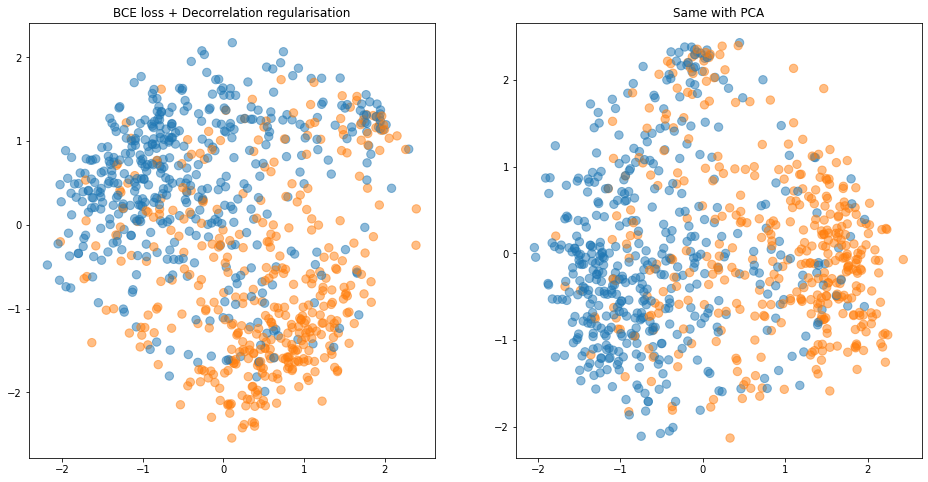

In [23]:
_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].scatter(target_embeddings[:, 0], target_embeddings[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.5, s=70)

pca = PCA(2)
pca.fit(target_embeddings)
target_pca = np.dot(target_embeddings, pca.components_.T)
axs[1].scatter(target_pca[:, 0], target_pca[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.5, s=70)

# axs[0].set_title('Original BCE loss')
axs[0].set_title('BCE loss + Decorrelation regularisation')
# axs[0].set_title('BCE loss + Distance exp regularisation')
# axs[0].set_title('BCE loss + Distance l2 regularisation')
axs[1].set_title('Same with PCA')
plt.show()

In [24]:
def get_line_borders(target_embeddings, w, b):
    x_max, y_max = target_embeddings.max(axis=0)
    x_min, y_min = target_embeddings.min(axis=0)
    
    w = w.detach().cpu().numpy().flatten()
    b = b.detach().cpu().numpy()[0]
    
    borders = []
    y = -(w[0] * x_max + b) / w[1]
    if y_min < y < y_max:
        borders.append((x_max, y))
    y = -(w[0] * x_min + b) / w[1]
    if y_min < y < y_max:
        borders.append((x_min, y))
        
    x = -(w[1] * y_max + b) / w[0]
    if x_min < x < x_max:
        borders.append((x, y_max))
    x = -(w[1] * y_min + b) / w[0]
    if x_min < x < x_max:
        borders.append((x, y_min))

    assert len(borders) == 2
    return list(zip(*borders))

In [25]:
def get_heatmap(ax, target_embeddings, w, b):
    x_max, y_max = target_embeddings.max(axis=0)
    x_min, y_min = target_embeddings.min(axis=0)
    w = w.detach().cpu().numpy().flatten()
    b = b.detach().cpu().numpy()[0]
    
    n = 100
    X = np.linspace(x_min, x_max, n).reshape(1, n).repeat(n, axis=0)
    Y = np.linspace(y_min, y_max, n).reshape(n, 1).repeat(n, axis=1)
    
    Z = (w[0] * X.flatten() + w[1] * Y.flatten() + b).reshape(n, n)
    Z = 1 / (1 + np.exp(-Z))
    ax.contourf(X, Y, Z, cmap='RdBu_r', levels=100, alpha=0.6, antialiased=True)

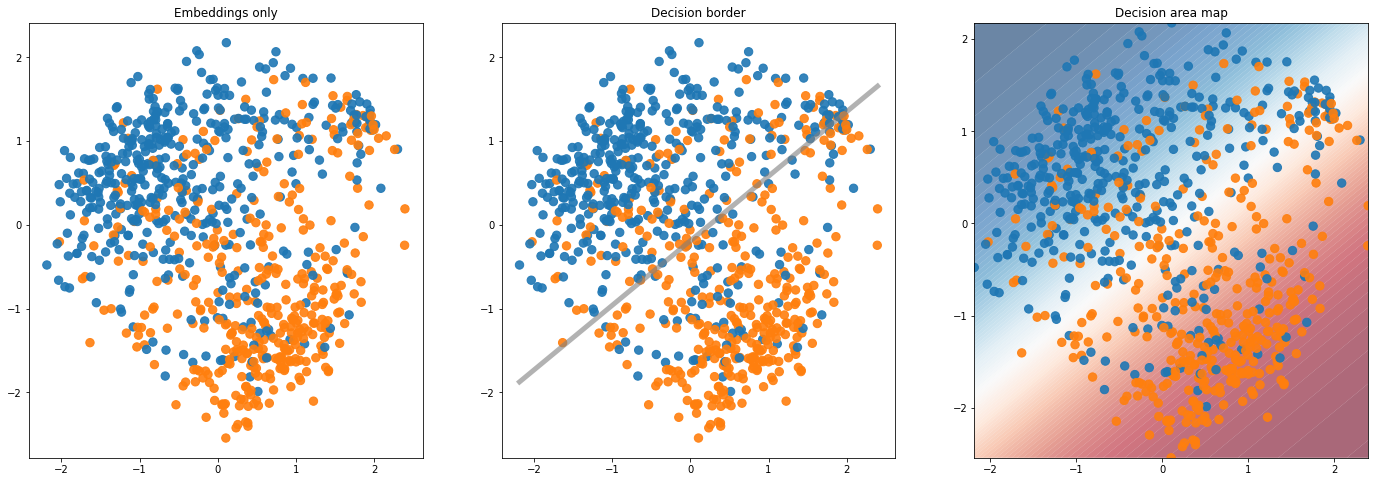

In [26]:
_, axs = plt.subplots(1, 3, figsize=(8 * 3, 8))

axs[1].plot(*get_line_borders(target_embeddings, target_model.head2[0].weight, target_model.head2[0].bias),
           linewidth=5, alpha=0.6, color='gray')
get_heatmap(axs[2], target_embeddings, target_model.head2[0].weight, target_model.head2[0].bias)  

for ax in axs[:3]:
    ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], c=plt.get_cmap('tab10')(y), alpha=0.9, s=70)

axs[0].set_title('Embeddings only')
axs[1].set_title('Decision border')
axs[2].set_title('Decision area map')

plt.show()

In [27]:
l_conf = conf['substitute']

_substitute_trainer_params = l_conf['trainer']
if 'logger_name' in l_conf:
    _substitute_trainer_params['logger'] = pl.loggers.TensorBoardLogger(
        save_dir='lightning_logs',
        name=l_conf.get('logger_name'),
    )
_substitute_trainer_params['callbacks'] = [
    pl.callbacks.EarlyStopping(monitor='val_auroc', mode='max', min_delta=0.0005, patience=2)
]
substitute_trainer = pl.Trainer(**_substitute_trainer_params)

substitute_model = SequenceToTarget(l_conf['params'])
substitute_dm = AdversarialTrainDataModule(conf['data_module'], target_model, *data_splitter.substitute_files)
substitute_trainer.fit(substitute_model, substitute_dm)

substitute_valid_metrics = {name: float(mf.compute().item()) for name, mf in substitute_model.valid_metrics.items()}
print(', '.join([f'valid_{name}: {v:.4f}' for name, v in substitute_valid_metrics.items()]))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


0it [00:00, ?it/s]

2021-06-07 09:57:05,418 INFO    setup_map              : Loaded 3797 for train model


0it [00:00, ?it/s]

2021-06-07 09:57:05,476 INFO    setup_map              : Loaded 370 for valid model
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]
2021-06-07 09:57:05,483 INFO    get_lr_scheduler       : StepLR lr_scheduler used

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | BCELoss       | 0     
1 | _seq_encoder  | RnnSeqEncoder | 29.8 K
2 | _head         | Sequential    | 145   
3 | train_metrics | ModuleDict    | 0     
4 | valid_metrics | ModuleDict    | 0     
5 | test_metrics  | ModuleDict    | 0     
------------------------------------------------
29.9 K    Trainable params
0         Non-trainable params
29.9 K    Total params
0.120     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

valid_auroc: 0.8071, valid_accuracy: 0.7441


In [28]:
substitute_trainer.test(model=substitute_model, test_dataloaders=test_dm.test_dataloader())
substitute_test_metrics = {name: float(mf.compute().item()) for name, mf in substitute_model.test_metrics.items()}
print(', '.join([f'test_{name}: {v:.4f}' for name, v in substitute_test_metrics.items()]))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7749999761581421, 'test_auroc': 0.8632344007492065}
--------------------------------------------------------------------------------
test_auroc: 0.8632, test_accuracy: 0.7750


In [29]:
target_valid_metrics, target_test_metrics, substitute_valid_metrics, substitute_test_metrics

({'auroc': 0.8412981629371643, 'accuracy': 0.7750887870788574},
 {'auroc': 0.8578282594680786, 'accuracy': 0.7892857193946838},
 {'auroc': 0.8070823550224304, 'accuracy': 0.7440884709358215},
 {'auroc': 0.8632344007492065, 'accuracy': 0.7749999761581421})

# MCC description

In [40]:
!ls data/*.csv

data/gender_test_kaggle_sample_submission.csv  data/tr_mcc_codes.csv
data/gender_train.csv			       data/tr_types.csv
data/test_ids.csv			       data/transactions.csv


In [41]:
df_trx = pd.read_csv('data/transactions.csv')

In [42]:
mcc_dict = pd.merge(
    df_trx['mcc_code'].value_counts(),
    pd.read_csv('data/tr_mcc_codes.csv', sep=';').set_index('mcc_code'),
    left_index=True, right_index=True,
)

mcc_dict = mcc_dict.drop(columns='mcc_code').reset_index()
mcc_dict['mcc_description'] = mcc_dict['index'].astype(str) + ": " + mcc_dict['mcc_description']
mcc_dict.index = range(2, 2 + len(mcc_dict))

mcc_dict = mcc_dict['mcc_description'].to_dict()

In [43]:
type_dict = pd.merge(
    df_trx['tr_type'].value_counts(),
    pd.read_csv('data/tr_types.csv', sep=';').set_index('tr_type'),
    left_index=True, right_index=True,
)

type_dict = type_dict.drop(columns='tr_type').reset_index()
type_dict.index = range(2, 2 + len(type_dict))
type_dict = type_dict['tr_description'].to_dict()

In [85]:
df_mcc_freq = [[], [], []]

for rec in chain(
    substitute_dm.train_dataloader().dataset,
    substitute_dm.val_dataloader().dataset,
):
    for i, k in enumerate(['mcc_code', 'tr_type', 'amount']):
        df_mcc_freq[i].append(rec[0][k].numpy())

df_mcc_freq = pd.DataFrame({
    'mcc_code': np.concatenate(df_mcc_freq[0]),
    'tr_type': np.concatenate(df_mcc_freq[1]), 
    'amount': np.concatenate(df_mcc_freq[2]),
})

In [86]:
df_mcc_freq1 = df_mcc_freq
df_mcc_freq = df_mcc_freq.groupby('mcc_code')
df_mcc_freq = pd.concat([
    df_mcc_freq.apply(lambda x: x['tr_type'].value_counts(normalize=True).rename('tr_type_freq'))
], axis=1)

df_mcc_freq = pd.concat([
    df_mcc_freq,
    df_mcc_freq1.groupby(['mcc_code', 'tr_type']).apply(lambda x: x['amount'].quantile([0.25, 0.75])) 
    .rename(columns={0.25: 'a_min', 0.75: 'a_max'}),
], axis=1)

In [87]:
df_mcc_freq

tr_type_freq      a_min      a_max
mcc_code                                       
2        3       0.732100 -11.628901  -9.508702
         8       0.172395  10.019498  12.322043
         16      0.041678 -11.811221  -9.914143
         18      0.022787  -9.077959  -7.717316
         25      0.007589  -7.206785  -5.132499
...                   ...        ...        ...
183      5       0.777778  -9.644377  -8.531695
         21      0.111111 -10.697713 -10.697713
184      10      1.000000 -10.009449 -10.009449
185      5       0.333333 -11.649997 -10.305903
         21      0.666667 -11.108982  -9.959304

[826 rows x 3 columns]

In [88]:
df_mcc_freq.loc[2]

tr_type_freq      a_min      a_max
3       0.732100 -11.628901  -9.508702
8       0.172395  10.019498  12.322043
16      0.041678 -11.811221  -9.914143
18      0.022787  -9.077959  -7.717316
25      0.007589  -7.206785  -5.132499
26      0.007359  10.712623  12.909828
27      0.005238 -11.628901  -9.662842
28      0.005234  -7.717316  -7.717316
31      0.002703 -12.429820 -10.756883
34      0.001704  -8.164271  -7.717316
36      0.000846  10.019498  13.015188
47      0.000269  -7.835049  -6.227189
56      0.000023   8.525729   8.525729
64      0.000051  11.628901  13.826117
73      0.000023  12.676535  12.676535

In [95]:
mcc_dict[2]

'6011: Финансовые институты — снятие наличности автоматически'

In [173]:
type_dict[3], type_dict[8], type_dict[28]

('Выдача наличных в АТМ Сбербанк России',
 'Взнос наличных через АТМ (в своем тер.банке)',
 'Плата за получение наличных в АТМ. Россия')

# Attacks

In [282]:
class GreadyAttacker:
    def __init__(self):
        self._src = None
        
        self.max_mcc = 70
        self.tr_for_mcc = {}
        for m in range(2, self.max_mcc):
            t = df_mcc_freq.loc[m]['tr_type_freq']
            t = t.index[torch.multinomial(
                torch.from_numpy(t.values), 1000, replacement=True).numpy()].values.tolist()
            self.tr_for_mcc[m] = cycle(t)
            
        self.amount_dist = df_mcc_freq[['a_min', 'a_max']].to_dict(orient='index')

    def __call__(self, src):
        self._src = src
        return iter(self)

    def __iter__(self):
        for i, rec in enumerate(self._src):
            for t in self.process(i, rec):
                yield t

    def process(self, i, x):
        # original record
        rec, y = x
        yield rec, {'id': i, 'y': y, 'new_trx': None, 'new_trx_len': 0}
        
        mcc_len = 2
        for new_mcc in product(*[range(2, self.max_mcc) for _ in range(mcc_len)]):
            new_rec = {}
            new_rec['mcc_code'] = torch.cat([rec['mcc_code'], torch.tensor(new_mcc)])
            
            v = rec['event_time'][-1]
            new_rec['event_time'] = torch.cat([rec['event_time'], torch.tensor([v + 1, v + 2])])
            
            new_tr_type = []
            new_amount = []
            for m in new_mcc:
                t = next(self.tr_for_mcc[m])
                new_tr_type.append(t)
                
                ix = (rec['mcc_code'] == m) & (rec['tr_type'] == t)
                if ix.sum() == 0:
                    # no such trx for this client, sample similar trx
                    v = self.amount_dist[(m, t)]
                    a = random.random() * (v['a_max'] - v['a_min']) + v['a_min']
                else:
                    # take amount from history
                    v = rec['amount'][ix]
                    a = v[random.choice(range(len(v)))].item()         
                new_amount.append(a)
                
            new_rec['tr_type'] = torch.cat([rec['tr_type'], torch.tensor(new_tr_type)])
            new_rec['amount'] = torch.cat([rec['amount'], torch.tensor(new_amount)])
                
            yield new_rec, {'id': i, 'y': y, 'new_trx': {
                'mcc_code': list(new_mcc),
                'tr_type': new_tr_type,
                'amount': new_amount,
            }, 'new_trx_len': len(new_mcc)}

In [283]:
class AdversarialAttackDataModule(pl.LightningDataModule):
    def __init__(self, conf, pl_module, *files):
        super().__init__()

        self.mode = None
        
        self.setup_conf = conf['setup']
        self.test_conf = conf.get('test', conf['valid'])
        
        self.test_files = files

        self.col_id = self.setup_conf['col_id']
        self.col_id_dtype = {
            'str': str,
            'int': int,
        }[self.setup_conf['col_id_dtype']]
        self.col_target = self.setup_conf['col_target']
        self.y_cast = int
        self.category_names = pl_module.seq_encoder.category_names
        self.category_names.add('event_time')
        self.category_max_size = pl_module.seq_encoder.category_max_size

    def prepare_data(self):
        self.load_target()
        self.setup_iterable_files()

    def load_target(self):
        df = pd.read_csv(self.setup_conf['target_file_path'])
        df[self.col_id] = df[self.col_id].astype(self.col_id_dtype)
        df[self.col_target] = df[self.col_target].astype(self.y_cast)
        self._targets = df.set_index(self.col_id)[self.col_target].to_dict()
        
    def setup_iterable_files(self):
        self.test_dataset = ParquetDataset(
            self.test_files,
            post_processing=IterableChain(*self.build_iterable_processing('test')),
            shuffle_files=False,
        )

    def build_iterable_processing(self, part):
        yield FeatureTypeCast({self.col_id: self.col_id_dtype})
        yield IdFilter(id_col=self.col_id, relevant_ids=list(self._targets.keys()))
        
        yield TargetJoin(self.col_id, self._targets, self.y_cast)

        yield FeatureFilter(keep_feature_names=self.category_names)
        yield CategorySizeClip(self.category_max_size)
        yield IterableAugmentations(self.build_augmentations(part))
        
        yield GreadyAttacker()

    def build_augmentations(self, part):
        return build_augmentations(self.test_conf['augmentations'])

    def test_dataloader(self):
        return DataLoader(
            dataset=self.test_dataset,
            collate_fn=padded_collate,
            shuffle=False,
            num_workers=self.test_conf['num_workers'],
            batch_size=self.test_conf['batch_size'],
            drop_last=False,
        )

In [284]:
attack_dm = AdversarialAttackDataModule(conf['data_module'], target_model, *data_splitter.test_files)
attack_dm.prepare_data()

In [286]:
# list(islice(iter(attack_dm.test_dataloader().dataset), 5))

In [287]:
class AttackTestModel(torch.nn.Module):
    def __init__(self, target_model, substitute_model):
        super().__init__()
        
        self.target_emb_model = torch.nn.Sequential(
            target_model._seq_encoder,
            *target_model._head,
        )
        self.target_head = torch.nn.Sequential(
            *target_model.head2,
        )
        self.substitute_model = substitute_model

    def forward(self, x):
        t_emb = self.target_emb_model(x)
        t_score = self.target_head(t_emb).unsqueeze(-1)
        s_score = self.substitute_model(x).unsqueeze(-1)
        return torch.cat([t_emb, t_score, s_score], dim=1)

attack_test_model = AttackTestModel(target_model, substitute_model)

In [288]:
%%time
ts, original_scores = tuple(score_model2(attack_test_model, attack_dm.test_dataloader(), {'device': 'cuda'}))
for rec, t_x, t_y, t_score, s_score, in zip(original_scores, *ts.T):
    rec['t_x'] = t_x
    rec['t_y'] = t_y
    rec['t_score'] = t_score
    rec['s_score'] = s_score


CPU times: user 4min 36s, sys: 27.8 s, total: 5min 3s
Wall time: 14min 36s


In [289]:
len(original_scores)

3885000

In [293]:
with open('original_scores.pickle', 'wb') as f:
    pickle.dump(original_scores, f)

## Load from dump

In [528]:
%%time
with open('original_scores.pickle', 'rb') as f:
    original_scores = pickle.load(f)

CPU times: user 38.8 s, sys: 7.27 s, total: 46.1 s
Wall time: 45.9 s


In [529]:
for t in original_scores:
    v = t.get('new_mcc_len', t.get('new_trx_len'))
    t['new_trx_len'] = v

In [530]:
original_scores[95:105]

array([{'id': 0, 'y': 0, 'new_trx': {'mcc_code': [3, 28], 'tr_type': [6, 22], 'amount': [10.158226021712665, 11.213578400361486]}, 'new_mcc_len': 2, 't_x': -0.9175616, 't_y': 0.7995529, 't_score': 0.1251857, 's_score': 0.041466877, 'new_trx_len': 2},
       {'id': 0, 'y': 0, 'new_trx': {'mcc_code': [3, 29], 'tr_type': [11, 5], 'amount': [11.854103813043407, -9.961649536853653]}, 'new_mcc_len': 2, 't_x': -1.4129357, 't_y': 0.9126859, 't_score': 0.07505073, 's_score': 0.039174996, 'new_trx_len': 2},
       {'id': 0, 'y': 0, 'new_trx': {'mcc_code': [3, 30], 'tr_type': [50, 32], 'amount': [11.807499326361196, 10.46668661772193]}, 'new_mcc_len': 2, 't_x': -1.0517077, 't_y': 0.8620101, 't_score': 0.105804965, 's_score': 0.032616735, 'new_trx_len': 2},
       {'id': 0, 'y': 0, 'new_trx': {'mcc_code': [3, 31], 'tr_type': [6, 2], 'amount': [9.845546608330757, -9.857117416171123]}, 'new_mcc_len': 2, 't_x': -1.0762851, 't_y': 1.0408114, 't_score': 0.08619679, 's_score': 0.060358632, 'new_trx_len'

In [531]:
# check accuracy
np.mean([(rec['t_score'] > 0.5) == rec['y'] for rec in original_scores if rec['new_trx_len'] == 0])

0.7892857142857143

In [532]:
# check accuracy
np.mean([(rec['s_score'] > 0.5) == rec['y'] for rec in original_scores if rec['new_trx_len'] == 0])

0.775

In [533]:
df_test_all = pd.DataFrame(original_scores.tolist())
df_test_orig = df_test_all[lambda x: x['new_trx_len'].eq(0)][['id', 's_score', 't_score', 't_x', 't_y', 'y']] \
    .rename(columns={'s_score': 's_score_orig', 't_score': 't_score_orig', 't_x': 't_x_orig', 't_y': 't_y_orig'})

df_test = pd.merge(
    df_test_all[lambda x: ~x['new_trx_len'].eq(0)],
    df_test_orig.drop(columns='y'),
    on='id',
).assign(s_p_drop=lambda x: x['s_score_orig'] - x['s_score']) \
.assign(t_p_drop=lambda x: x['t_score_orig'] - x['t_score'])

In [534]:
df_test_orig.head()

id  s_score_orig  t_score_orig  t_x_orig  t_y_orig  y
0       0      0.049233      0.089915 -0.867838  1.161090  0
4625    1      0.447656      0.707909  0.841973 -0.312671  0
9250    2      0.896975      0.774926  0.117990 -1.177065  1
13875   3      0.414402      0.925322  0.514363 -1.988802  0
18500   4      0.962710      0.868931  0.844575 -1.188602  1

In [535]:
df_test_orig.sort_values('s_score_orig').iloc[::80]

id  s_score_orig  t_score_orig  t_x_orig  t_y_orig  y
3084875  667      0.009732      0.067444 -1.703531  0.789060  0
2011875  435      0.040387      0.096161 -0.971214  1.016804  0
1766750  382      0.078568      0.103458 -0.784732  1.089666  0
2664000  576      0.147961      0.179490 -0.556956  0.707254  0
3621375  783      0.260793      0.566613  0.049777 -0.384860  1
2331000  504      0.381814      0.223786 -1.233040 -0.054770  0
208125    45      0.488941      0.558981  1.983895  1.133138  0
1974875  427      0.652375      0.647716  1.689011  0.581281  1
407000    88      0.830727      0.778585  0.481267 -0.915442  1
490250   106      0.935723      0.908088  0.793456 -1.576092  1
2349500  508      0.975828      0.922962  0.423857 -2.029193  1

In [536]:
(df_test_orig['s_score_orig'].ge(0.5) == df_test_orig['y']).mean(), \
(df_test_orig['t_score_orig'].ge(0.5) == df_test_orig['y']).mean()

(0.775, 0.7892857142857143)

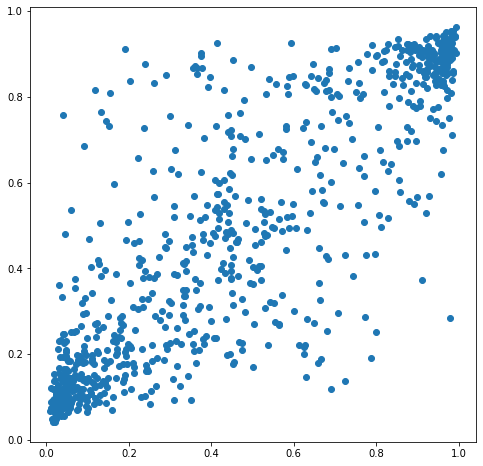

In [537]:
plt.figure(figsize=(8, 8))
plt.scatter(df_test_orig['s_score_orig'], df_test_orig['t_score_orig'])
plt.show()

In [538]:
df_test

id  y                                            new_trx  \
0          0  0  {'mcc_code': [2, 2], 'tr_type': [3, 3], 'amoun...   
1          0  0  {'mcc_code': [2, 3], 'tr_type': [3, 6], 'amoun...   
2          0  0  {'mcc_code': [2, 4], 'tr_type': [3, 4], 'amoun...   
3          0  0  {'mcc_code': [2, 5], 'tr_type': [3, 2], 'amoun...   
4          0  0  {'mcc_code': [2, 6], 'tr_type': [3, 7], 'amoun...   
...      ... ..                                                ...   
3884155  839  0  {'mcc_code': [69, 65], 'tr_type': [5, 2], 'amo...   
3884156  839  0  {'mcc_code': [69, 66], 'tr_type': [12, 2], 'am...   
3884157  839  0  {'mcc_code': [69, 67], 'tr_type': [10, 5], 'am...   
3884158  839  0  {'mcc_code': [69, 68], 'tr_type': [10, 2], 'am...   
3884159  839  0  {'mcc_code': [69, 69], 'tr_type': [10, 12], 'a...   

         new_trx_len       t_x       t_y   t_score   s_score  new_mcc_len  \
0                  2 -0.721046  1.327874  0.085010  0.061313          2.0   
1                  2 -0.821901  1.353639  0.076225  0.046419          2.0   
2                  2 -0.622485  1.448085  0.081149  0.063789          2.0   
3                  2 -1.538860  0.733093  0.081886  0.054013          2.0   
4                  2 -1.238371  0.896984  0.087917  0.065898          2.0   
...              ...       ...       ...       ...       ...          ...   
3884155            2  0.731144  0.286180  0.525211  0.859481          2.0   
3884156            2  0.704776 -0.090554  0.624676  0.775067          2.0   
3884157            2  0.869849 -0.133716  0.669243  0.896191          2.0   
3884158            2  0.928031  0.259743  0.575711  0.887432          2.0   
3884159            2  1.104250  0.111804  0.652593  0.964547          2.0   

         s_score_orig  t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  
0            0.049233      0.089915 -0.867838  1.161090 -0.012080  0.004905  
1            0.049233      0.089915 -0.867838  1.161090  0.002813  0.013690  
2            0.049233      0.089915 -0.867838  1.161090 -0.014556  0.008766  
3            0.049233      0.089915 -0.867838  1.161090 -0.004780  0.008029  
4            0.049233      0.089915 -0.867838  1.161090 -0.016665  0.001998  
...               ...           ...       ...       ...       ...       ...  
3884155      0.631093      0.489516  1.533847  1.029601 -0.228388 -0.035695  
3884156      0.631093      0.489516  1.533847  1.029601 -0.143975 -0.135160  
3884157      0.631093      0.489516  1.533847  1.029601 -0.265098 -0.179728  
3884158      0.631093      0.489516  1.533847  1.029601 -0.256339 -0.086195  
3884159      0.631093      0.489516  1.533847  1.029601 -0.333455 -0.163077  

[3884160 rows x 15 columns]

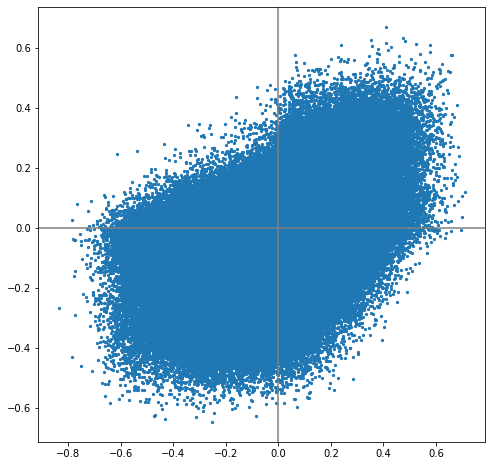

In [539]:
plt.figure(figsize=(8, 8))
plt.scatter(df_test['s_p_drop'], df_test['t_p_drop'], s=5)
plt.axvline(0, color='gray')
plt.axhline(0, color='gray')
plt.show()

In [540]:
np.isin([2, 5], [1, 2, 3, 4])

array([ True, False])

In [541]:
top_popular_mcc_ix = df_test['new_trx'].str['mcc_code'].apply(lambda x: np.isin(x, range(2, 10)).all())
top_popular_mcc_ix

0           True
1           True
2           True
3           True
4           True
           ...  
3884155    False
3884156    False
3884157    False
3884158    False
3884159    False
Name: new_trx, Length: 3884160, dtype: bool

In [542]:
for _id in [37]:
    print('id', _id)
    display(df_test[lambda x: x['id'].eq(_id)].sort_values('s_p_drop', ascending=False).iloc[::1000])
    display(df_test[lambda x: x['id'].eq(_id) & top_popular_mcc_ix].sample(n=10))

id 37


id  y                                            new_trx  new_trx_len  \
174193  37  0  {'mcc_code': [47, 47], 'tr_type': [5, 5], 'amo...            2   
171628  37  0  {'mcc_code': [9, 66], 'tr_type': [2, 2], 'amou...            2   
175622  37  0  {'mcc_code': [68, 48], 'tr_type': [2, 2], 'amo...            2   
173946  37  0  {'mcc_code': [44, 4], 'tr_type': [2, 4], 'amou...            2   
175117  37  0  {'mcc_code': [61, 19], 'tr_type': [2, 2], 'amo...            2   

             t_x       t_y   t_score   s_score  new_mcc_len  s_score_orig  \
174193 -1.091144  0.787178  0.110721  0.061900          2.0      0.537858   
171628  0.160874  0.953695  0.237210  0.405127          2.0      0.537858   
175622  0.415259  0.798921  0.317373  0.513717          2.0      0.537858   
173946  0.488984  1.308082  0.216814  0.585740          2.0      0.537858   
175117  0.087977  0.795502  0.259009  0.687943          2.0      0.537858   

        t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  
174193      0.221233  1.089653  1.748577  0.475957  0.110512  
171628      0.221233  1.089653  1.748577  0.132731 -0.015978  
175622      0.221233  1.089653  1.748577  0.024141 -0.096140  
173946      0.221233  1.089653  1.748577 -0.047883  0.004418  
175117      0.221233  1.089653  1.748577 -0.150085 -0.037776

id  y                                            new_trx  new_trx_len  \
171089  37  0  {'mcc_code': [2, 3], 'tr_type': [8, 6], 'amoun...            2   
171227  37  0  {'mcc_code': [4, 5], 'tr_type': [4, 5], 'amoun...            2   
171570  37  0  {'mcc_code': [9, 8], 'tr_type': [2, 2], 'amoun...            2   
171565  37  0  {'mcc_code': [9, 3], 'tr_type': [5, 9], 'amoun...            2   
171364  37  0  {'mcc_code': [6, 6], 'tr_type': [14, 7], 'amou...            2   
171161  37  0  {'mcc_code': [3, 7], 'tr_type': [9, 2], 'amoun...            2   
171297  37  0  {'mcc_code': [5, 7], 'tr_type': [2, 2], 'amoun...            2   
171360  37  0  {'mcc_code': [6, 2], 'tr_type': [7, 3], 'amoun...            2   
171363  37  0  {'mcc_code': [6, 5], 'tr_type': [15, 21], 'amo...            2   
171298  37  0  {'mcc_code': [5, 8], 'tr_type': [5, 5], 'amoun...            2   

             t_x       t_y   t_score   s_score  new_mcc_len  s_score_orig  \
171089  0.861716  1.803949  0.178968  0.394644          2.0      0.537858   
171227 -0.889265  0.624853  0.152004  0.470395          2.0      0.537858   
171570  0.512470  0.892525  0.312755  0.528830          2.0      0.537858   
171565  0.523017  0.960786  0.298136  0.388043          2.0      0.537858   
171364 -0.508131  0.459943  0.232687  0.586068          2.0      0.537858   
171161  0.332554  1.247150  0.205429  0.440063          2.0      0.537858   
171297 -0.225089  0.792292  0.210145  0.472931          2.0      0.537858   
171360  0.312685  1.180996  0.215104  0.550289          2.0      0.537858   
171363 -1.127937  0.123363  0.205046  0.556074          2.0      0.537858   
171298 -0.742650  0.283110  0.231880  0.558153          2.0      0.537858   

        t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  
171089      0.221233  1.089653  1.748577  0.143213  0.042265  
171227      0.221233  1.089653  1.748577  0.067463  0.069229  
171570      0.221233  1.089653  1.748577  0.009027 -0.091523  
171565      0.221233  1.089653  1.748577  0.149815 -0.076903  
171364      0.221233  1.089653  1.748577 -0.048211 -0.011454  
171161      0.221233  1.089653  1.748577  0.097794  0.015804  
171297      0.221233  1.089653  1.748577  0.064927  0.011088  
171360      0.221233  1.089653  1.748577 -0.012431  0.006129  
171363      0.221233  1.089653  1.748577 -0.018216  0.016186  
171298      0.221233  1.089653  1.748577 -0.020295 -0.010647

In [543]:
df_best_attacks = df_test.groupby('id').apply(lambda x: x.sort_values('s_p_drop', ascending=False).iloc[0])
df_best_attacks

id  y                                            new_trx  new_trx_len  \
id                                                                            
0      0  0  {'mcc_code': [39, 47], 'tr_type': [5, 5], 'amo...            2   
1      1  0  {'mcc_code': [47, 66], 'tr_type': [5, 5], 'amo...            2   
2      2  1  {'mcc_code': [66, 16], 'tr_type': [5, 5], 'amo...            2   
3      3  0  {'mcc_code': [52, 47], 'tr_type': [5, 5], 'amo...            2   
4      4  1  {'mcc_code': [3, 16], 'tr_type': [9, 5], 'amou...            2   
..   ... ..                                                ...          ...   
835  835  1  {'mcc_code': [16, 47], 'tr_type': [10, 2], 'am...            2   
836  836  0  {'mcc_code': [47, 47], 'tr_type': [2, 5], 'amo...            2   
837  837  0  {'mcc_code': [66, 47], 'tr_type': [5, 5], 'amo...            2   
838  838  0  {'mcc_code': [52, 24], 'tr_type': [5, 5], 'amo...            2   
839  839  0  {'mcc_code': [66, 47], 'tr_type': [5, 5], 'amo...            2   

          t_x       t_y   t_score   s_score  new_mcc_len  s_score_orig  \
id                                                                       
0   -1.431739  1.205465  0.053974  0.014799          2.0      0.049233   
1   -0.723483 -0.682346  0.481460  0.066740          2.0      0.447656   
2    0.076243 -0.703902  0.658612  0.507438          2.0      0.896975   
3    0.044311 -1.895585  0.880250  0.125286          2.0      0.414402   
4    0.666091 -0.642340  0.751703  0.893787          2.0      0.962710   
..        ...       ...       ...       ...          ...           ...   
835 -0.195010 -0.591859  0.571758  0.778694          2.0      0.950606   
836 -1.361460  0.273560  0.150136  0.038842          2.0      0.355328   
837 -0.326006 -0.403646  0.489390  0.018741          2.0      0.409324   
838 -0.959932  0.683883  0.135982  0.044918          2.0      0.109749   
839 -0.414573 -0.038722  0.368427  0.031565          2.0      0.631093   

     t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop  
id                                                         
0        0.089915 -0.867838  1.161090  0.034434  0.035941  
1        0.707909  0.841973 -0.312671  0.380916  0.226449  
2        0.774926  0.117990 -1.177065  0.389537  0.116314  
3        0.925322  0.514363 -1.988802  0.289115  0.045072  
4        0.868931  0.844575 -1.188602  0.068923  0.117228  
..            ...       ...       ...       ...       ...  
835      0.775366  0.100475 -1.192772  0.171912  0.203609  
836      0.437277 -0.020143  0.015150  0.316486  0.287141  
837      0.606668  1.830649  0.843741  0.390583  0.117278  
838      0.133659 -1.597513  0.209775  0.064832 -0.002323  
839      0.489516  1.533847  1.029601  0.599528  0.121089  

[840 rows x 15 columns]

In [544]:
# mean p_drop
df_best_attacks['t_p_drop'].mean()

0.12177934799165953

In [545]:
# new accuracy
df_best_attacks.assign(t_new_acc=lambda x: x['t_score'].ge(0.5) == x['y'])['t_new_acc'].mean()

0.7452380952380953

In [546]:
# original confusion matrix
df_best_attacks \
    .assign(t_pred=lambda x: x['t_score_orig'].ge(0.5).astype(int)).pivot_table(
        index='t_pred', columns='y', values='id', aggfunc=len,
)

y         0    1
t_pred          
0       366   97
1        80  297

In [547]:
# new confusion matrix
df_best_attacks \
    .assign(t_pred=lambda x: x['t_score'].ge(0.5).astype(int)).pivot_table(
        index='t_pred', columns='y', values='id', aggfunc=len,
)

y         0    1
t_pred          
0       401  169
1        45  225

In [548]:
# top attack mcc
df_best_attacks['new_trx'].str['mcc_code'].apply(tuple).value_counts()

(52, 47)    111
(47, 30)     80
(47, 47)     58
(66, 47)     47
(2, 47)      45
(39, 52)     42
(47, 16)     42
(52, 39)     41
(39, 47)     41
(47, 39)     34
(16, 47)     34
(66, 16)     32
(47, 52)     21
(16, 30)     19
(66, 30)     18
(52, 52)     17
(16, 16)     13
(30, 30)      9
(3, 47)       9
(32, 47)      9
(52, 24)      8
(16, 39)      8
(39, 39)      8
(39, 30)      8
(30, 47)      7
(47, 24)      7
(3, 16)       6
(66, 52)      5
(24, 30)      5
(52, 30)      5
(24, 47)      4
(37, 39)      4
(47, 66)      4
(7, 16)       4
(3, 52)       3
(52, 18)      3
(52, 66)      3
(3, 39)       3
(24, 39)      2
(37, 52)      2
(30, 16)      2
(32, 52)      1
(52, 16)      1
(37, 24)      1
(39, 18)      1
(16, 66)      1
(66, 18)      1
(66, 39)      1
(24, 52)      1
(16, 9)       1
(18, 47)      1
(32, 39)      1
(2, 16)       1
(16, 24)      1
(66, 24)      1
(3, 30)       1
(3, 24)       1
(24, 24)      1
Name: new_trx, dtype: int64

In [549]:
mcc_dict[52], mcc_dict[47], mcc_dict[30], mcc_dict[66], mcc_dict[39], mcc_dict[16]

('5943: Магазины офисных, школьных принадлежностей, канцтоваров',
 '5621: Готовая женская одежда',
 '5651: Одежда для всей семьи',
 '5631: Аксессуары для женщин',
 '5699: Различные магазины одежды и аксессуаров',
 '5977: Магазины косметики')

# Examples

Подбираем разные примеры:
- разные примеры по эффективности атаки (разные по диапазону t_p_drop)
- разные по сложности (по исходной вероятности класса)

In [550]:
t_score_quantiles = [0.5 if i == 2 else a
                     for i, a in enumerate(df_best_attacks['t_score_orig'].quantile([0, 0.25, 0.5, 0.75, 1]))]
t_score_quantiles

[0.04111076518893242,
 0.17839690297842026,
 0.5,
 0.8249094188213348,
 0.9636071920394897]

In [551]:
df_best_attacks['t_p_drop'].quantile([0, 0.25, 0.5, 0.75, 1])

0.00   -0.028865
0.25    0.040919
0.50    0.092322
0.75    0.174670
1.00    0.594579
Name: t_p_drop, dtype: float64

In [552]:
df_best_attacks['t_score_orig_bin'] = pd.cut(
    df_best_attacks['t_score_orig'],
    t_score_quantiles,
    labels=range(4),
).fillna(0)
df_best_attacks['t_p_drop_bin'] = pd.cut(
    df_best_attacks['t_p_drop'],
    df_best_attacks['t_p_drop'].quantile([0, 0.25, 0.5, 0.75, 1]).values,
    labels=range(4),
).fillna(0)

In [553]:
df_best_attacks.groupby(['y', 't_score_orig_bin', 't_p_drop_bin']).apply(lambda x: x.sample(n=2)).loc[[1]] \
    [['id', 'y', 'new_trx', 'new_trx_len', 's_p_drop', 't_score_orig', 't_score', 't_p_drop']]

id  y  \
y t_score_orig_bin t_p_drop_bin id            
1 0                0            29    29  1   
                                5      5  1   
                   1            580  580  1   
                                240  240  1   
  1                0            401  401  1   
                                652  652  1   
                   1            92    92  1   
                                764  764  1   
                   2            99    99  1   
                                673  673  1   
                   3            94    94  1   
                                601  601  1   
  2                0            743  743  1   
                                802  802  1   
                   1            567  567  1   
                                325  325  1   
                   2            729  729  1   
                                678  678  1   
                   3            702  702  1   
                                179  179  1   
  3                0            426  426  1   
                                33    33  1   
                   1            256  256  1   
                                744  744  1   
                   2            809  809  1   
                                367  367  1   
                   3            532  532  1   
                                120  120  1   

                                                                               new_trx  \
y t_score_orig_bin t_p_drop_bin id                                                       
1 0                0            29   {'mcc_code': [52, 39], 'tr_type': [2, 5], 'amo...   
                                5    {'mcc_code': [52, 47], 'tr_type': [2, 5], 'amo...   
                   1            580  {'mcc_code': [52, 47], 'tr_type': [5, 5], 'amo...   
                                240  {'mcc_code': [52, 47], 'tr_type': [2, 5], 'amo...   
  1                0            401  {'mcc_code': [39, 52], 'tr_type': [5, 5], 'amo...   
                                652  {'mcc_code': [66, 47], 'tr_type': [5, 5], 'amo...   
                   1            92   {'mcc_code': [47, 39], 'tr_type': [5, 5], 'amo...   
                                764  {'mcc_code': [52, 39], 'tr_type': [5, 5], 'amo...   
                   2            99   {'mcc_code': [47, 30], 'tr_type': [5, 5], 'amo...   
                                673  {'mcc_code': [52, 47], 'tr_type': [5, 5], 'amo...   
                   3            94   {'mcc_code': [52, 47], 'tr_type': [2, 5], 'amo...   
                                601  {'mcc_code': [47, 47], 'tr_type': [2, 5], 'amo...   
  2                0            743  {'mcc_code': [2, 47], 'tr_type': [34, 5], 'amo...   
                                802  {'mcc_code': [66, 30], 'tr_type': [5, 5], 'amo...   
                   1            567  {'mcc_code': [66, 16], 'tr_type': [5, 5], 'amo...   
                                325  {'mcc_code': [52, 30], 'tr_type': [5, 5], 'amo...   
                   2            729  {'mcc_code': [47, 47], 'tr_type': [2, 5], 'amo...   
                                678  {'mcc_code': [66, 16], 'tr_type': [5, 5], 'amo...   
                   3            702  {'mcc_code': [47, 16], 'tr_type': [5, 5], 'amo...   
                                179  {'mcc_code': [39, 47], 'tr_type': [5, 5], 'amo...   
  3                0            426  {'mcc_code': [66, 30], 'tr_type': [5, 5], 'amo...   
                                33   {'mcc_code': [2, 47], 'tr_type': [3, 5], 'amou...   
                   1            256  {'mcc_code': [16, 16], 'tr_type': [5, 10], 'am...   
                                744  {'mcc_code': [30, 47], 'tr_type': [5, 5], 'amo...   
                   2            809  {'mcc_code': [52, 47], 'tr_type': [2, 5], 'amo...   
                                367  {'mcc_code': [47, 16], 'tr_type': [2, 5], 'amo...   
                   3            532  {'mcc_code': [66, 16], 'tr_type': [5, 5], 'amo...   
                 

In [554]:
# успешная атака
df_best_attacks[lambda x: x['t_score_orig_bin'].eq(3) & x['t_score'].lt(0.4)] \
    .sort_values('t_p_drop', ascending=True)

id  y                                            new_trx  new_trx_len  \
id                                                                            
71    71  1  {'mcc_code': [16, 47], 'tr_type': [5, 5], 'amo...            2   
110  110  0  {'mcc_code': [47, 47], 'tr_type': [5, 2], 'amo...            2   
222  222  1  {'mcc_code': [16, 47], 'tr_type': [5, 2], 'amo...            2   
741  741  1  {'mcc_code': [16, 47], 'tr_type': [5, 5], 'amo...            2   
687  687  1  {'mcc_code': [47, 47], 'tr_type': [2, 5], 'amo...            2   
329  329  1  {'mcc_code': [16, 47], 'tr_type': [10, 5], 'am...            2   

          t_x       t_y   t_score   s_score  new_mcc_len  s_score_orig  \
id                                                                       
71  -0.931988 -0.475436  0.378581  0.275717          2.0      0.679211   
110 -0.835058 -0.366185  0.369315  0.228866          2.0      0.844807   
222 -0.560781 -0.232915  0.390414  0.873064          2.0      0.970104   
741 -0.600673 -0.110937  0.349639  0.431786          2.0      0.818667   
687 -0.707168  0.148213  0.266636  0.123020          2.0      0.627895   
329 -0.341126  0.149246  0.334139  0.559570          2.0      0.975792   

     t_score_orig  t_x_orig  t_y_orig  s_p_drop  t_p_drop t_score_orig_bin  \
id                                                                           
71       0.838292 -0.155371 -1.744829  0.403494  0.459711                3   
110      0.856795  0.650879 -1.248385  0.615942  0.487480                3   
222      0.896431  0.634583 -1.583114  0.097039  0.506017                3   
741      0.882427  1.006117 -1.172327  0.386881  0.532788                3   
687      0.830495  1.861995 -0.140487  0.504875  0.563859                3   
329      0.928717  1.624118 -1.177126  0.416222  0.594579                3   

    t_p_drop_bin  
id                
71             3  
110            3  
222            3  
741            3  
687            3  
329            3

In [555]:
selected_ids = [
    {'id': 222, 'name': 'Успешная атака на сильно уверенный класс'},
    {'id': 367, 'name': 'Хорошая атака на сильно уверенный класс'},
    {'id': 530, 'name': 'Слабая атака на сильно уверенный класс'},
    {'id': 426, 'name': 'Очень слабая атака на сильно уверенный класс'},

    {'id': 585, 'name': 'Успешная атака на слабо уверенный класс'},
    {'id': 162, 'name': 'Хорошая атака на слабо уверенный класс'},
    {'id': 132, 'name': 'Слабая атака на слабо уверенный класс'},
    {'id': 25, 'name': 'Очень слабая атака на слабо уверенный класс'},

    {'id': 408, 'name': 'Успешная атака на неуверенный класс'},
    {'id': 385, 'name': 'Хорошая атака на неуверенный класс'},
    {'id': 277, 'name': 'Слабая атака на неуверенный класс'},
    {'id': 401, 'name': 'Очень слабая атака на неуверенный класс'},
     
    {'id': 352, 'name': 'Слабая атака на сильно неуверенный класс'},
    {'id': 56, 'name': 'Очень слабая атака на сильно неуверенный класс'},
]

In [556]:
for rec in selected_ids:
    # display(df_test[top_popular_mcc_ix & df_test['id'].eq(rec['id'])].sample(n=1))
    rec['most_popular'] = df_test[top_popular_mcc_ix & df_test['id'].eq(rec['id'])].sample(n=1).iloc[0].to_dict()
    rec['random'] = df_test[df_test['id'].eq(rec['id'])].sample(n=1).iloc[0].to_dict()
    
    top_k = 1 if rec['id'] in (222, 367, 585) else 5
    rec['most_adversarial'] = df_test[df_test['id'].eq(rec['id'])] \
        .sort_values('s_p_drop', ascending=False).iloc[:top_k].sample(n=1).iloc[0].to_dict()

In [557]:
 df_test[df_test['id'].eq(222)].sort_values('s_p_drop', ascending=False).iloc[0].loc['new_trx']

{'mcc_code': [16, 47],
 'tr_type': [5, 2],
 'amount': [-9.358566972103034, -10.56912890695742]}

In [558]:
def plot_example(rec):
    _, axs = plt.subplots(1, 3, figsize=(6 * 3, 6))

    for ax in axs:
        ax.plot(*get_line_borders(
            target_embeddings, target_model.head2[0].weight, target_model.head2[0].bias),
            linewidth=5, alpha=0.6, color='gray')

        ax.scatter(
            df_test_orig['t_x_orig'], 
            df_test_orig['t_y_orig'],
            c=df_test_orig['y'].apply(plt.get_cmap('tab10')), alpha=0.5
        )
        ax.scatter(
            df_test_orig[lambda x: x['id'].eq(rec['id'])]['t_x_orig'], 
            df_test_orig[lambda x: x['id'].eq(rec['id'])]['t_y_orig'],
            c='black', marker='*', s=600,
        )
        ax.scatter(
            df_test_orig[lambda x: x['id'].eq(rec['id'])]['t_x_orig'], 
            df_test_orig[lambda x: x['id'].eq(rec['id'])]['t_y_orig'],
            c='green', marker='*', s=400,
        )

    axs[0].scatter(rec['most_popular']['t_x'], rec['most_popular']['t_y'], c='black', marker='*', s=600)
    axs[0].scatter(rec['most_popular']['t_x'], rec['most_popular']['t_y'], c='red', marker='*', s=400)
    t = rec["most_popular"]["new_trx"]['mcc_code']
    axs[0].set_title(f'Most popular: {t}')

    axs[1].scatter(rec['random']['t_x'], rec['random']['t_y'], c='black', marker='*', s=600)
    axs[1].scatter(rec['random']['t_x'], rec['random']['t_y'], c='red', marker='*', s=400)
    t = rec["random"]["new_trx"]['mcc_code']
    axs[1].set_title(f'Random: {t}')

    axs[2].scatter(rec['most_adversarial']['t_x'], rec['most_adversarial']['t_y'], c='black', marker='*', s=600)
    axs[2].scatter(rec['most_adversarial']['t_x'], rec['most_adversarial']['t_y'], c='red', marker='*', s=400)
    t = rec["most_adversarial"]["new_trx"]['mcc_code']
    axs[2].set_title(f'Most adversarial: {t}')

    plt.suptitle(rec['name'])
    plt.show()

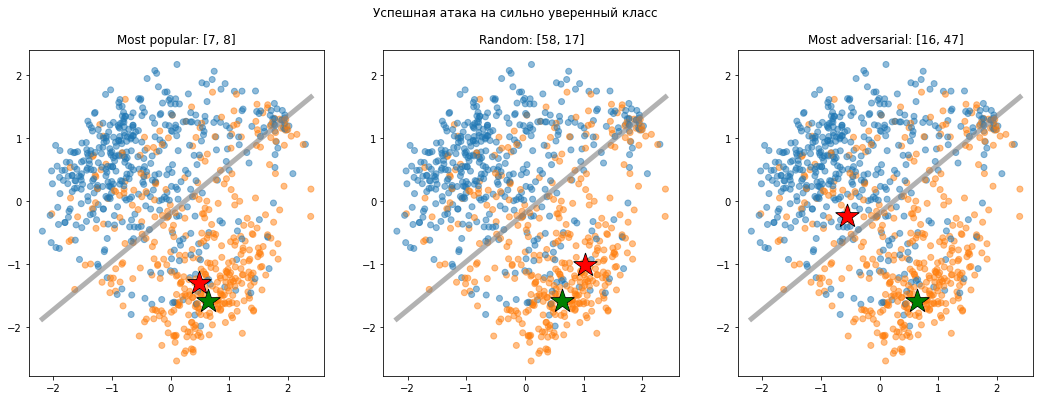

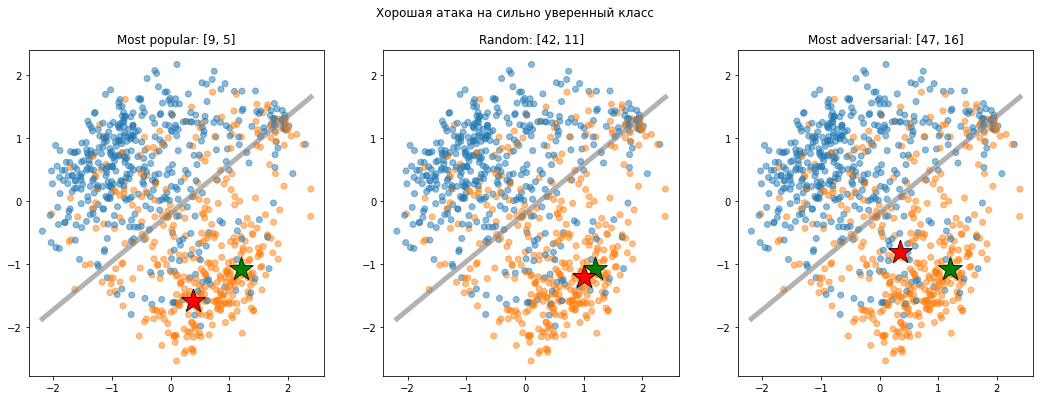

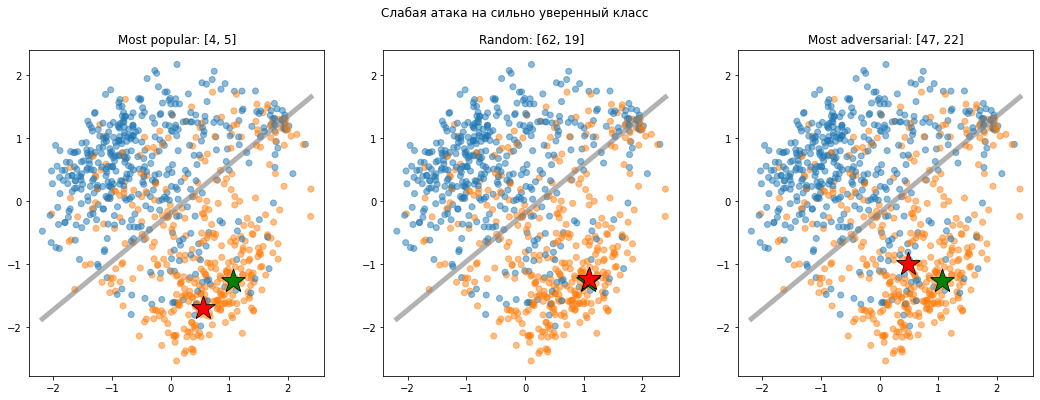

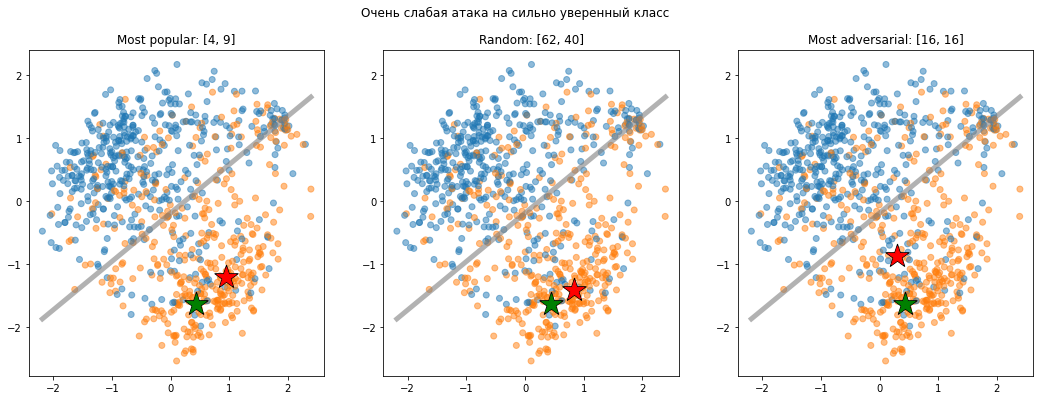

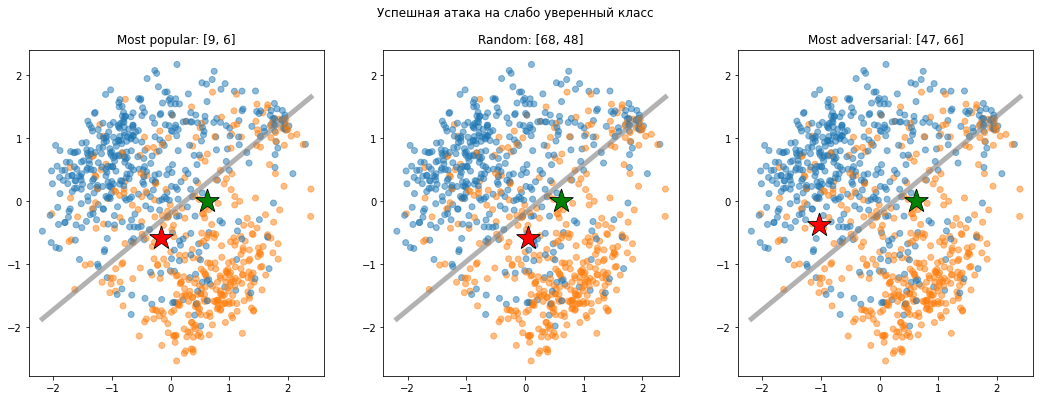

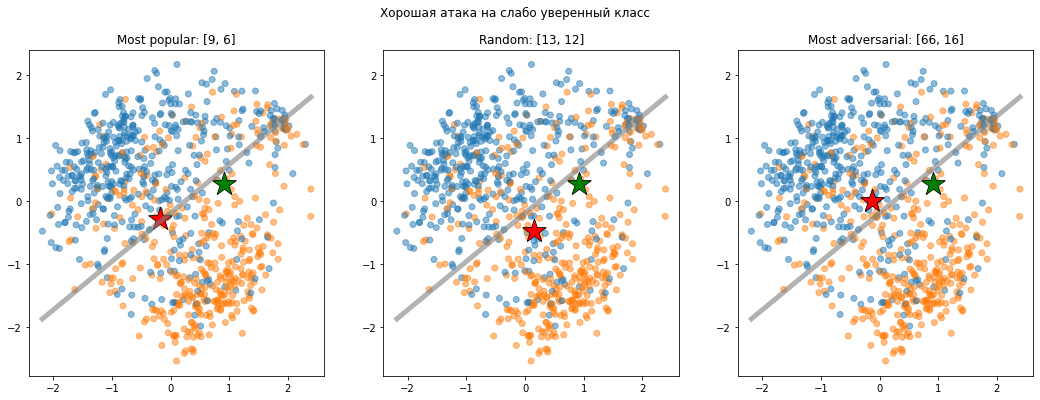

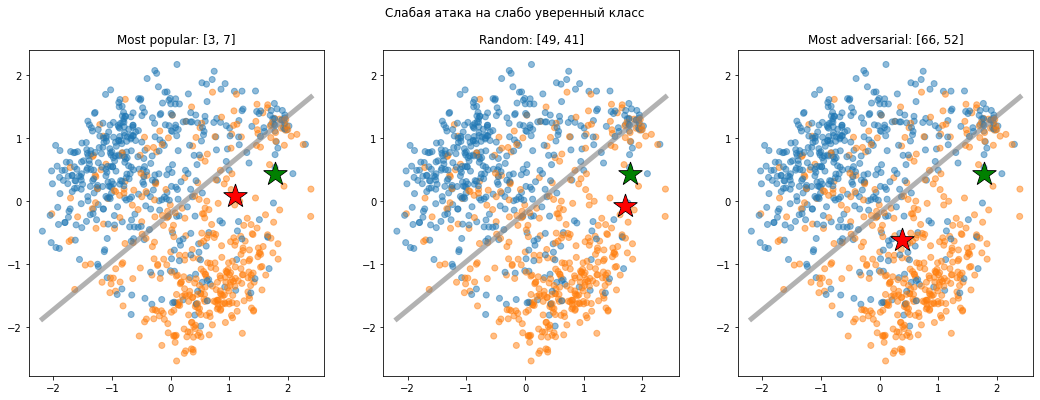

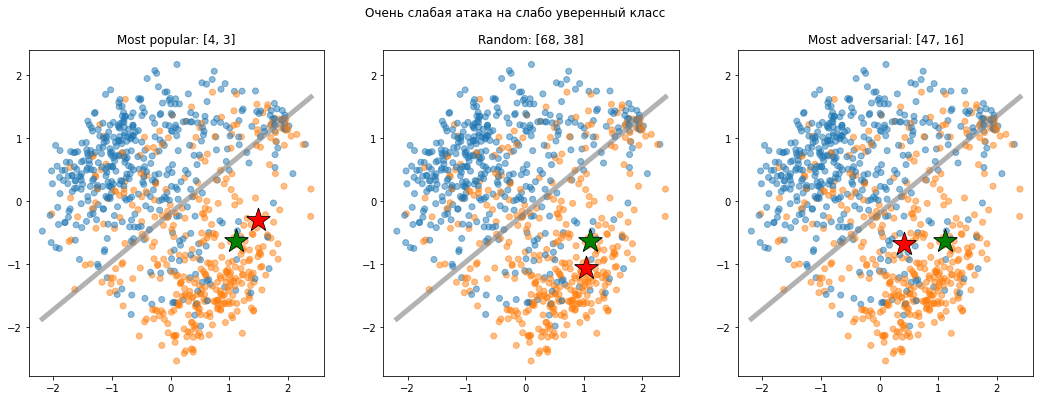

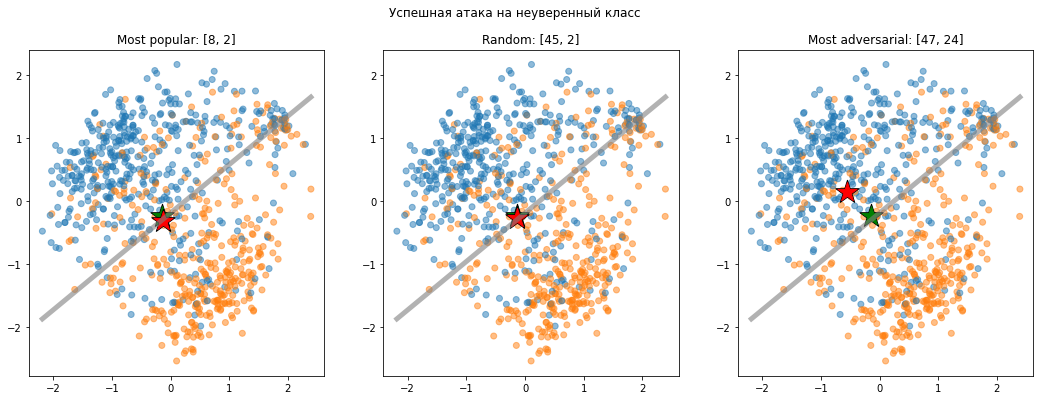

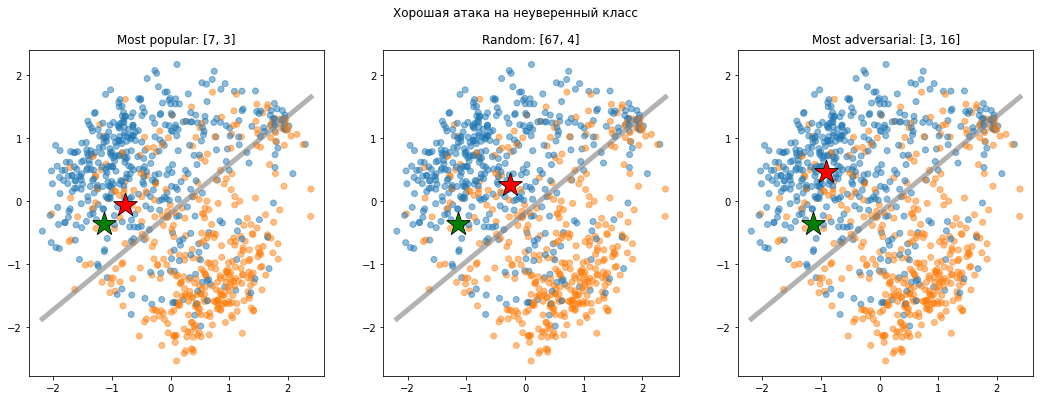

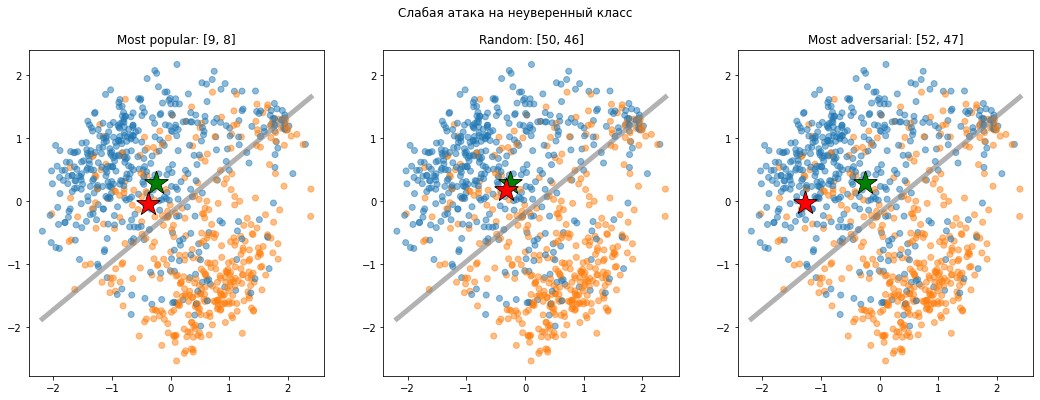

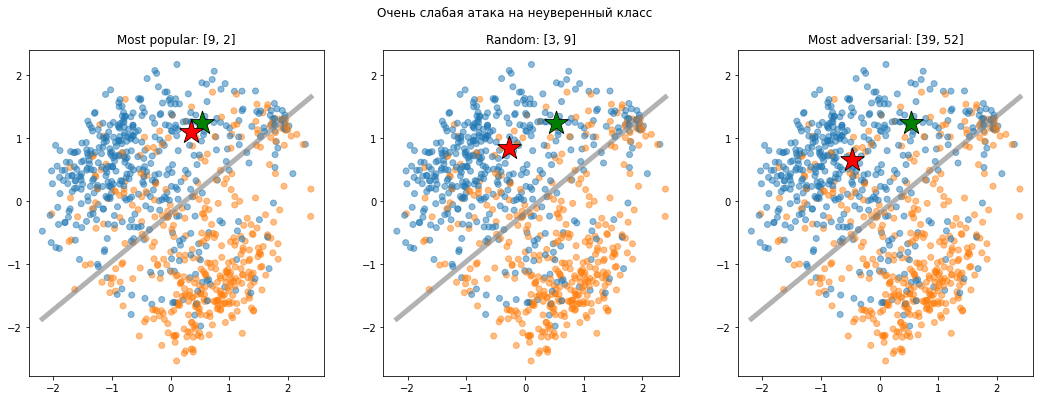

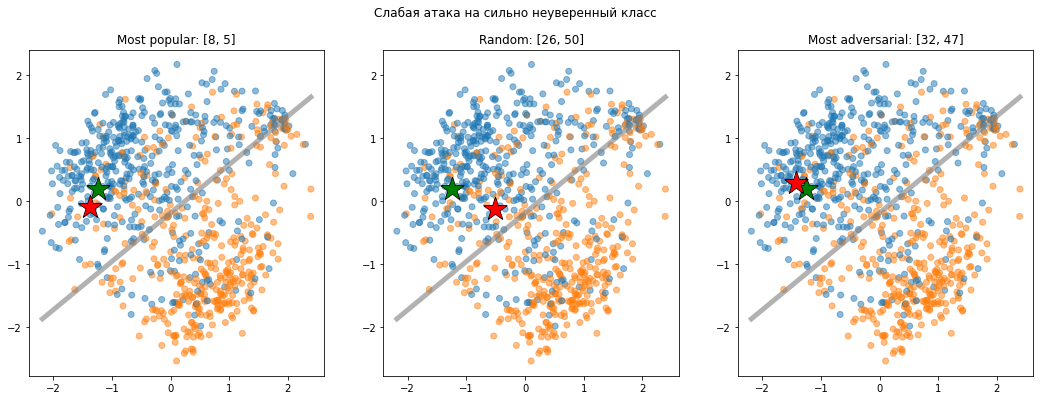

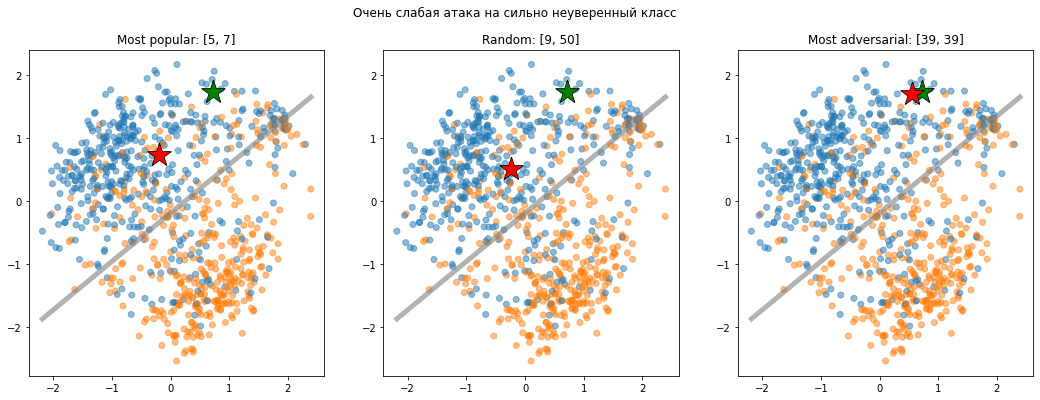

In [559]:
for p in selected_ids:
    plot_example(p)

In [560]:
# for trx in attack_dm.test_dataloader().dataset:
#     print(trx)
#     if trx[1]['new_mcc'] is not None:
#         continue
#     break

# Export

In [561]:
%%time
with jsonlines.open('original_scores.jsonl', 'w') as f:
    for rec in df_test_orig[['id', 't_score_orig', 't_x_orig', 't_y_orig', 'y']] \
        .assign(t_score_orig=lambda x: np.round(x['t_score_orig'], 3)) \
        .assign(t_x_orig=lambda x: np.round(x['t_x_orig'], 2)) \
        .assign(t_y_orig=lambda x: np.round(x['t_y_orig'], 2)) \
        .to_dict(orient='records'):
        f.write(rec)

CPU times: user 10.7 ms, sys: 0 ns, total: 10.7 ms
Wall time: 10.3 ms


In [562]:
!wc -l original_scores.jsonl
!ls -lh original_scores.jsonl
!head -n 3 original_scores.jsonl

840 original_scores.jsonl
-rw-r--r-- 1 ivan sudo 66K Jun  7 21:07 original_scores.jsonl
{"id": 0, "t_score_orig": 0.09, "t_x_orig": -0.87, "t_y_orig": 1.16, "y": 0}
{"id": 1, "t_score_orig": 0.708, "t_x_orig": 0.84, "t_y_orig": -0.31, "y": 0}
{"id": 2, "t_score_orig": 0.775, "t_x_orig": 0.12, "t_y_orig": -1.18, "y": 1}


In [563]:
%%time
with jsonlines.open('selected_trx.jsonl', 'w') as f:
    for trx in attack_dm.test_dataloader().dataset:
        if trx[1]['new_trx'] is not None:
            continue
        if trx[1]['id'] not in [x['id'] for x in selected_ids]:
            continue
    
        rec = trx[1]
        rec['trx'] = {k: v.numpy() for k, v in trx[0].items()}
        rec['trx']['amount'] = np.round(-1 * np.exp(abs(rec['trx']['amount'])) * np.sign(rec['trx']['amount']), 2)
        rec['trx']['event_time'] = np.round(rec['trx']['event_time'], 2)
        rec['trx'] = {k: v.tolist()[-10:] for k, v in rec['trx'].items()}
        
        f.write(rec)

CPU times: user 10min 38s, sys: 4.16 s, total: 10min 42s
Wall time: 10min 42s


In [564]:
!wc -l selected_trx.jsonl
!ls -lh selected_trx.jsonl
!head -n 2 selected_trx.jsonl

14 selected_trx.jsonl
-rw-r--r-- 1 ivan sudo 4.9K Jun  7 21:17 selected_trx.jsonl
{"id": 25, "y": 1, "new_trx": null, "new_trx_len": 0, "trx": {"amount": [336888.37, 89837.63, 53083.22, 179674.26, 224592.58, 139629.58, 224592.58, 336888.37, 224592.58, 148411.11], "event_time": [439.46, 439.63, 439.8, 440.64, 441.7, 442.55, 445.63, 447.66, 450.43, 450.61], "mcc_code": [2, 2, 5, 2, 2, 26, 2, 2, 2, 22], "tr_type": [3, 3, 2, 3, 3, 2, 3, 3, 3, 2]}}
{"id": 56, "y": 1, "new_trx": null, "new_trx_len": 0, "trx": {"amount": [-786071.52, -673775.73, 112296.79, -336888.37, -224592.58, -24706.07], "event_time": [330.69, 331.8, 338.66, 345.86, 350.79, 359.72], "mcc_code": [2, 2, 2, 2, 2, 2], "tr_type": [8, 8, 3, 8, 8, 8]}}


In [646]:
%%time

with open('selected_attacks.jsonl', 'wt') as f:
    for t in selected_ids:
        t = deepcopy(t)
        for k in ['most_popular', 'random', 'most_adversarial']:
            t[k]['new_trx']['amount'] = [float(x) for x in np.round(-1 * np.exp(np.abs(t[k]['new_trx']['amount'])) * 
                                      np.sign(t[k]['new_trx']['amount']), 2)]
            for k2 in t[k].keys():
                if type(t[k][k2]) is np.float64:
                    t[k][k2] = np.round(t[k][k2], 3)
        f.write(json.dumps(t, default=str))
        f.write('\n')

CPU times: user 10.5 ms, sys: 0 ns, total: 10.5 ms
Wall time: 9.66 ms


In [647]:
!wc -l selected_attacks.jsonl
!ls -lh selected_attacks.jsonl
!head -n 2 selected_attacks.jsonl

14 selected_attacks.jsonl
-rw-r--r-- 1 ivan sudo 18K Jun  8 07:43 selected_attacks.jsonl
{"id": 222, "name": "\u0423\u0441\u043f\u0435\u0448\u043d\u0430\u044f \u0430\u0442\u0430\u043a\u0430 \u043d\u0430 \u0441\u0438\u043b\u044c\u043d\u043e \u0443\u0432\u0435\u0440\u0435\u043d\u043d\u044b\u0439 \u043a\u043b\u0430\u0441\u0441", "most_popular": {"id": "222", "y": "1", "new_trx": {"mcc_code": [7, 8], "tr_type": [2, 2], "amount": [9855.85, 16351.27]}, "new_trx_len": "2", "t_x": 0.493, "t_y": -1.302, "t_score": 0.847, "s_score": 0.976, "new_mcc_len": 2.0, "s_score_orig": 0.97, "t_score_orig": 0.896, "t_x_orig": 0.635, "t_y_orig": -1.583, "s_p_drop": -0.006, "t_p_drop": 0.05}, "random": {"id": "222", "y": "1", "new_trx": {"mcc_code": [58, 17], "tr_type": [12, 12], "amount": [5994.23, 7297.66]}, "new_trx_len": "2", "t_x": 1.016, "t_y": -1.009, "t_score": 0.863, "s_score": 0.983, "new_mcc_len": 2.0, "s_score_orig": 0.97, "t_score_orig": 0.896, "t_x_orig": 0.635, "t_y_orig": -1.583, "s_p_drop": 

In [567]:
with open('mcc_dict.json', 'wt') as f:
    json.dump(mcc_dict, f, indent=2)

In [568]:
with open('type_dict.json', 'wt') as f:
    json.dump(type_dict, f, indent=2)

In [569]:
!wc -l mcc_dict.json
!ls -lh mcc_dict.json
!head -n 2 mcc_dict.json

185 mcc_dict.json
-rw-r--r-- 1 ivan sudo 42K Jun  7 21:17 mcc_dict.json
{
  "2": "6011: \u0424\u0438\u043d\u0430\u043d\u0441\u043e\u0432\u044b\u0435 \u0438\u043d\u0441\u0442\u0438\u0442\u0443\u0442\u044b \u2014 \u0441\u043d\u044f\u0442\u0438\u0435 \u043d\u0430\u043b\u0438\u0447\u043d\u043e\u0441\u0442\u0438 \u0430\u0432\u0442\u043e\u043c\u0430\u0442\u0438\u0447\u0435\u0441\u043a\u0438",


In [570]:
!wc -l type_dict.json
!ls -lh type_dict.json
!head -n 2 type_dict.json

73 type_dict.json
-rw-r--r-- 1 ivan sudo 17K Jun  7 21:17 type_dict.json
{
  "2": "\u041f\u043e\u043a\u0443\u043f\u043a\u0430. POS \u0422\u0423 \u0421\u0411 \u0420\u0424",


In [573]:
!ls *.jsonl *.json adversarial.md

adversarial.md	original_scores.jsonl	selected_trx.jsonl
mcc_dict.json	selected_attacks.jsonl	type_dict.json


In [662]:
!zip adversarial_data.zip *.jsonl *.json adversarial.md

updating: original_scores.jsonl (deflated 87%)
updating: selected_attacks.jsonl (deflated 86%)
updating: selected_trx.jsonl (deflated 72%)
updating: mcc_dict.json (deflated 86%)
updating: type_dict.json (deflated 93%)
updating: adversarial.md (deflated 69%)


# Load from files and check

In [650]:
!ls *.jsonl *.json adversarial.md

adversarial.md	original_scores.jsonl	selected_trx.jsonl
mcc_dict.json	selected_attacks.jsonl	type_dict.json


In [651]:
with jsonlines.open('original_scores.jsonl', 'r') as f:
    chk_original_scores = list(iter(f))

In [652]:
with jsonlines.open('selected_trx.jsonl', 'r') as f:
    chk_selected_trx = list(iter(f))

In [653]:
with jsonlines.open('selected_attacks.jsonl', 'r') as f:
    chk_selected_attacks = list(iter(f))

In [654]:
with open('mcc_dict.json', 'rt') as f:
    chk_mcc_dict = json.load(f)
    
chk_mcc_dict = {int(k): v for k, v in chk_mcc_dict.items()}

## Visual

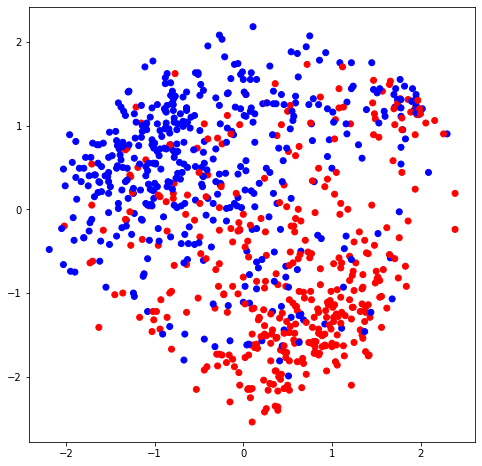

In [655]:
plt.figure(figsize=(8, 8))
plt.scatter(
    [x['t_x_orig'] for x in chk_original_scores],
    [x['t_y_orig'] for x in chk_original_scores],
    c = ['red' if x['y'] == 1 else 'blue' for x in chk_original_scores],
)
plt.show()

In [656]:
print('\n'.join(['Chose client for attack:'] + [f' - Client {x["id"]}' for x in chk_selected_trx]))

Chose client for attack:
 - Client 25
 - Client 56
 - Client 132
 - Client 162
 - Client 222
 - Client 277
 - Client 352
 - Client 367
 - Client 385
 - Client 401
 - Client 408
 - Client 426
 - Client 530
 - Client 585


In [ ]:
pd.options.display.max_colwidth

History for "Client 25" (Очень слабая атака на слабо уверенный класс)


mcc_code     amount
9                                         5200: Товары для дома 148,400.00
8  6011: Финансовые институты — снятие наличности автоматически 224,600.00
7  6011: Финансовые институты — снятие наличности автоматически 336,900.00
6  6011: Финансовые институты — снятие наличности автоматически 224,600.00
5                               5533: Автозапчасти и аксессуары 139,600.00
4  6011: Финансовые институты — снятие наличности автоматически 224,600.00
3  6011: Финансовые институты — снятие наличности автоматически 179,700.00
2                       5411: Бакалейные магазины, супермаркеты  53,100.00
1  6011: Финансовые институты — снятие наличности автоматически  89,800.00
0  6011: Финансовые институты — снятие наличности автоматически 336,900.00

mcc_code  \
1                6010: Финансовые институты — снятие наличности вручную   
0  4814: Звонки с использованием телефонов, считывающих магнитную ленту   

       amount  
1 -116,600.00  
0   11,200.00

mcc_code  \
1                              5732: Продажа электронного оборудования   
0  5719: Различные специализированные магазины бытовых принадлежностей   

     amount  
1 34,100.00  
0 80,000.00

mcc_code    amount
1      5977: Магазины косметики 12,800.00
0  5621: Готовая женская одежда 22,500.00

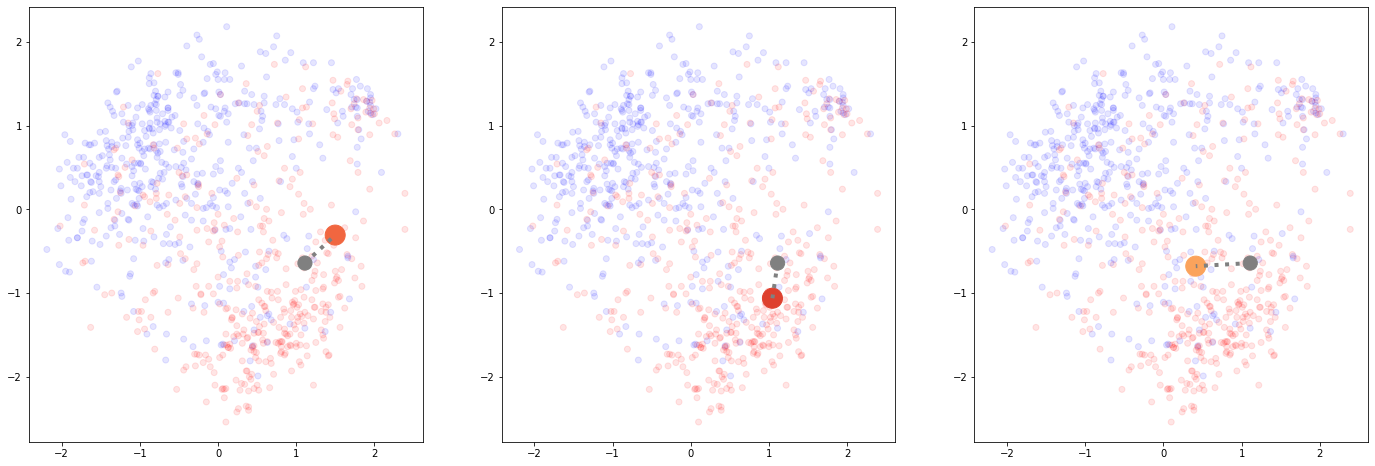

History for "Client 56" (Очень слабая атака на сильно неуверенный класс)


mcc_code      amount
5  6011: Финансовые институты — снятие наличности автоматически  -24,700.00
4  6011: Финансовые институты — снятие наличности автоматически -224,600.00
3  6011: Финансовые институты — снятие наличности автоматически -336,900.00
2  6011: Финансовые институты — снятие наличности автоматически  112,300.00
1  6011: Финансовые институты — снятие наличности автоматически -673,800.00
0  6011: Финансовые институты — снятие наличности автоматически -786,100.00

mcc_code  \
1  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
0                                                                                                                           5411: Бакалейные магазины, супермаркеты   

    amount  
1 6,200.00  
0 7,200.00

mcc_code    amount
1  5399: Различные товары общего назначения 12,400.00
0                              5912: Аптеки 16,000.00

mcc_code    amount
1  5699: Различные магазины одежды и аксессуаров 18,800.00
0  5699: Различные магазины одежды и аксессуаров 30,800.00

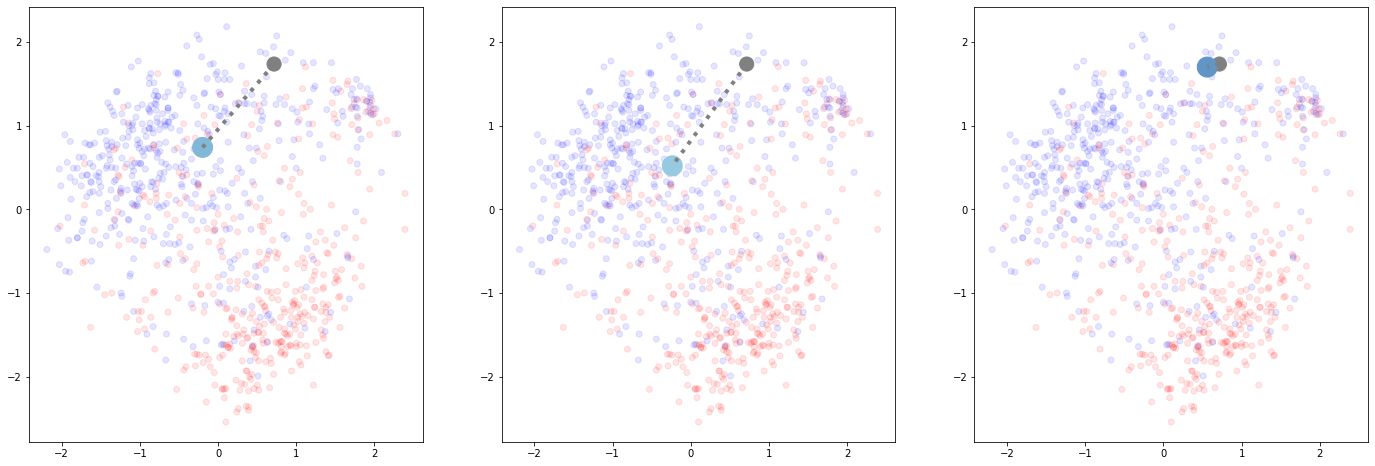

History for "Client 132" (Слабая атака на слабо уверенный класс)


mcc_code     amount
9  6011: Финансовые институты — снятие наличности автоматически  44,900.00
7  6011: Финансовые институты — снятие наличности автоматически 112,300.00
8  6011: Финансовые институты — снятие наличности автоматически  22,500.00
6  6011: Финансовые институты — снятие наличности автоматически  67,400.00
5  6011: Финансовые институты — снятие наличности автоматически 222,300.00
4  6011: Финансовые институты — снятие наличности автоматически 112,300.00
3         4899: Кабельные и другие платные телевизионные услуги  27,000.00
2  6011: Финансовые институты — снятие наличности автоматически  44,900.00
1  6011: Финансовые институты — снятие наличности автоматически  67,400.00
0  6011: Финансовые институты — снятие наличности автоматически  67,400.00

mcc_code  \
1  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
0                                                                                                            6010: Финансовые институты — снятие наличности вручную   

      amount  
1   2,700.00  
0 -65,400.00

mcc_code   amount
1              7994: Галереи/учреждения видеоигр 2,900.00
0  4816: Компьютерная сеть/информационные услуги 6,100.00

mcc_code    amount
1  5943: Магазины офисных, школьных принадлежностей, канцтоваров  6,800.00
0                                    5631: Аксессуары для женщин 25,500.00

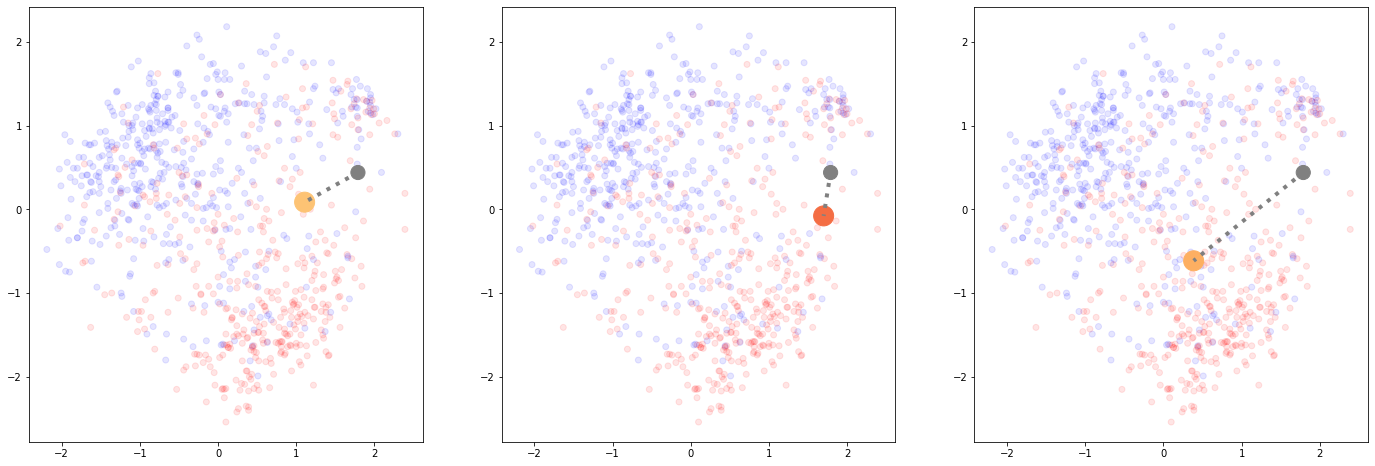

History for "Client 162" (Хорошая атака на слабо уверенный класс)


mcc_code  \
9                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
8  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
7                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
6                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
5                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
4                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
3                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
2                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
1                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
0                                                                                                                           5411: Бакалейные магазины, супермаркеты   

      amount  
9   3,400.00  
8   2,300.00  
7   3,400.00  
6   3,400.00  
5   3,400.00  
4 101,100.00  
3   3,400.00  
2   3,400.00  
1   3,400.00  
0   4,000.00

mcc_code   amount
1  4829: Денежные переводы   800.00
0             5912: Аптеки 8,000.00

mcc_code  \
1                                                5814: Рестораны, закусочные   
0  5921: Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)   

    amount  
1 8,100.00  
0 8,100.00

mcc_code   amount
1     5977: Магазины косметики 8,400.00
0  5631: Аксессуары для женщин 9,700.00

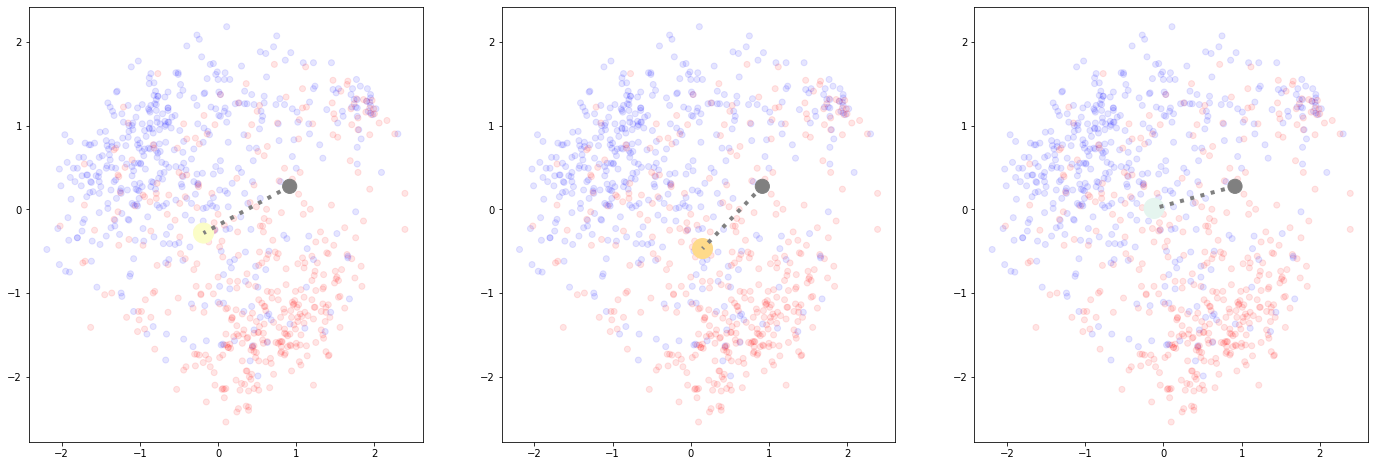

History for "Client 222" (Успешная атака на сильно уверенный класс)


mcc_code  \
9                                           5691: Магазины мужской и женской одежды   
8                            6010: Финансовые институты — снятие наличности вручную   
7                            6010: Финансовые институты — снятие наличности вручную   
5                                                           4829: Денежные переводы   
6                                                           4829: Денежные переводы   
4                            6010: Финансовые институты — снятие наличности вручную   
3  5511: Легковой и грузовой транспорт — продажа, сервис, ремонт, запчасти и лизинг   
2                            6010: Финансовые институты — снятие наличности вручную   
1                                                           4829: Денежные переводы   
0                                                           4829: Денежные переводы   

         amount  
9 -3,368,700.00  
8 -2,245,900.00  
7   -471,600.00  
5  2,245,900.00  
6     22,500.00  
4   -134,800.00  
3    158,100.00  
2 -1,433,100.00  
1    368,300.00  
0    709,700.00

mcc_code  \
1                                                                                                                                     5541: Станции техобслуживания   
0  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   

     amount  
1 16,400.00  
0  9,900.00

mcc_code   amount
1  5964: Прямой маркетинг — торговля через каталог 7,300.00
0                           4121: Лимузины и такси 6,000.00

mcc_code    amount
1  5621: Готовая женская одежда 38,900.00
0      5977: Магазины косметики 11,600.00

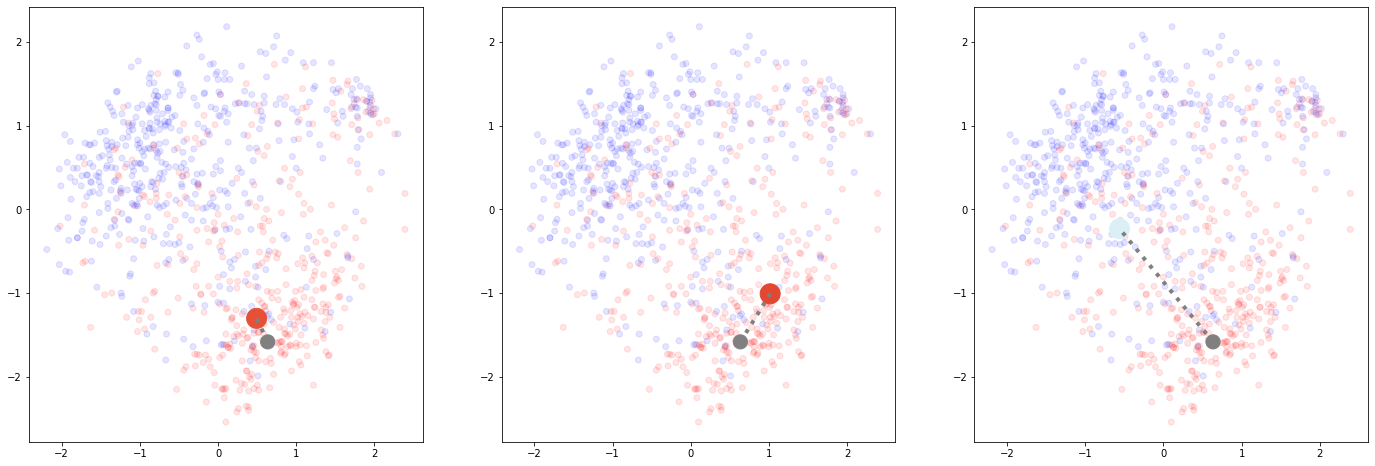

History for "Client 277" (Слабая атака на неуверенный класс)


mcc_code  \
8                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
9                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
6                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
7                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
5                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
4                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
3                                                                                                                                           4829: Денежные переводы   
2                                                                                                                           5411: Бакалейные магазины, супермаркеты   
1  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
0  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   

      amount  
8  16,800.00  
9 561,500.00  
6  27,000.00  
7 898,400.00  
5 673,800.00  
4  20,200.00  
3  89,800.00  
2  50,000.00  
1   8,300.00  
0  26,900.00

mcc_code    amount
1  5541: Станции техобслуживания 20,200.00
0                   5912: Аптеки  3,200.00

mcc_code  \
1  8099: Практикующие врачи, медицинские услуги, нигде ранее не классифицируемые   
0                                       5399: Различные товары общего назначения   

     amount  
1 40,300.00  
0 20,900.00

mcc_code    amount
1                                   5621: Готовая женская одежда 54,300.00
0  5943: Магазины офисных, школьных принадлежностей, канцтоваров  4,900.00

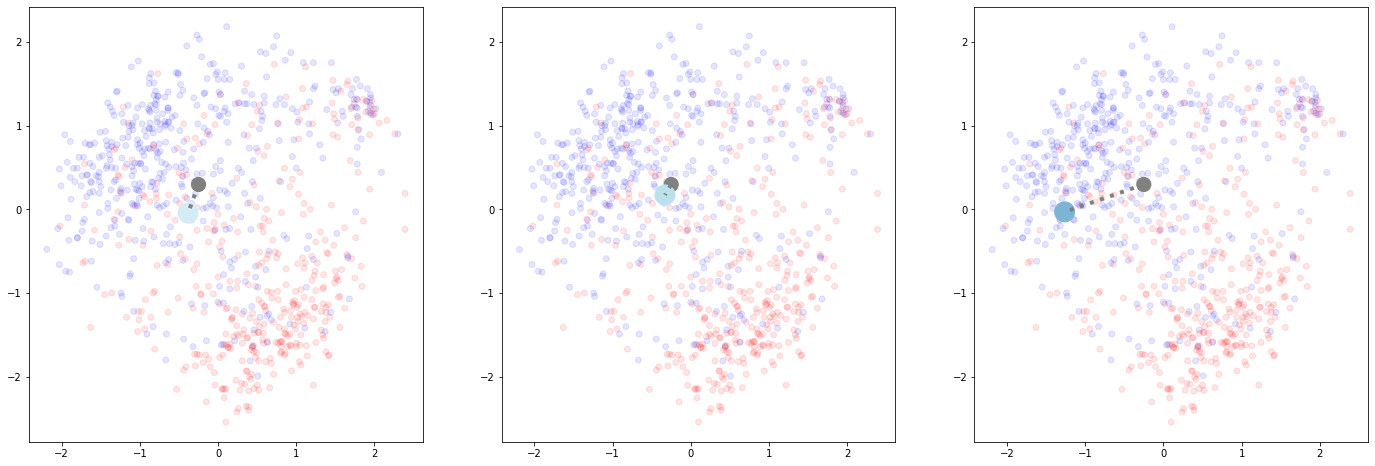

History for "Client 352" (Слабая атака на сильно неуверенный класс)


mcc_code     amount
7  6011: Финансовые институты — снятие наличности автоматически -67,400.00
8  6011: Финансовые институты — снятие наличности автоматически -44,900.00
9                                       4829: Денежные переводы 224,600.00
6  6011: Финансовые институты — снятие наличности автоматически -44,900.00
5                                       4829: Денежные переводы 224,600.00
4                                       4829: Денежные переводы  67,400.00
3                                       4829: Денежные переводы  44,900.00
2                                       4829: Денежные переводы  19,100.00
0  6011: Финансовые институты — снятие наличности автоматически -44,900.00
1                                       4829: Денежные переводы 224,600.00

mcc_code    amount
1  5411: Бакалейные магазины, супермаркеты 13,000.00
0            5541: Станции техобслуживания 16,300.00

mcc_code    amount
1  5399: Различные товары общего назначения 10,700.00
0           5533: Автозапчасти и аксессуары 29,600.00

mcc_code    amount
1  5621: Готовая женская одежда 53,300.00
0        5945: Магазины игрушек 10,400.00

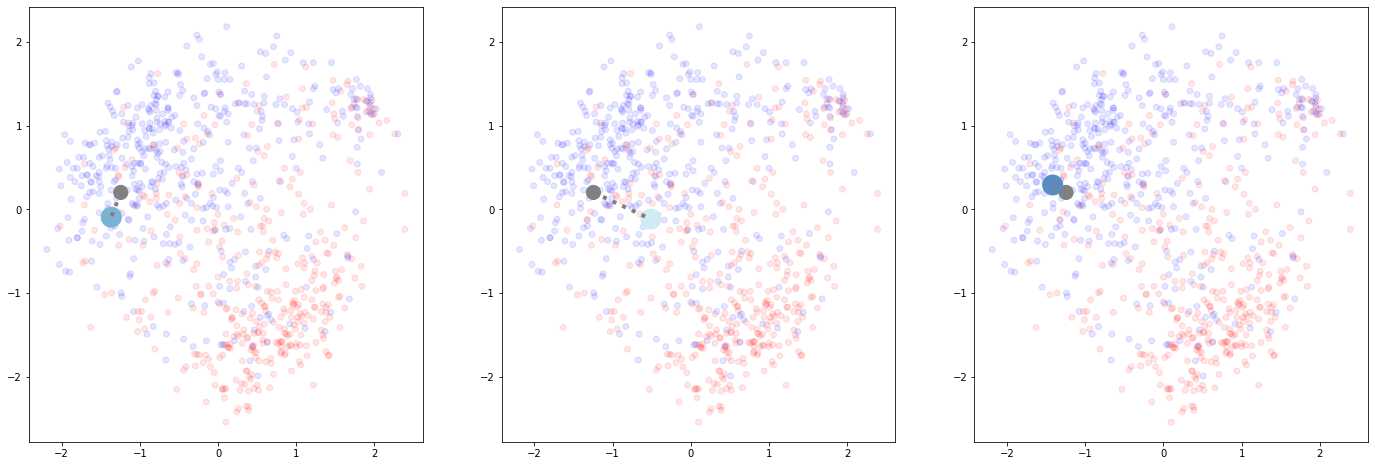

History for "Client 367" (Хорошая атака на сильно уверенный класс)


mcc_code  \
9                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
8                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
7                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
6  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
5                                                                                                                           5411: Бакалейные магазины, супермаркеты   
4  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
3                                                                                                   5983: Горючее топливо — уголь, нефть, разжиженный бензин, дрова   
1                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
2                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
0                                                                                                                                       7538: СТО общего назначения   

      amount  
9   2,200.00  
8   2,200.00  
7   6,700.00  
6   7,900.00  
5   1,000.00  
4  10,200.00  
3   6,700.00  
1 336,900.00  
2   4,500.00  
0  38,200.00

mcc_code    amount
1  5411: Бакалейные магазины, супермаркеты 27,000.00
0                             5912: Аптеки  6,600.00

mcc_code    amount
1  5812: Места общественного питания, рестораны  7,800.00
0                             5995: Зоомагазины 16,100.00

mcc_code    amount
1      5977: Магазины косметики 12,700.00
0  5621: Готовая женская одежда 52,500.00

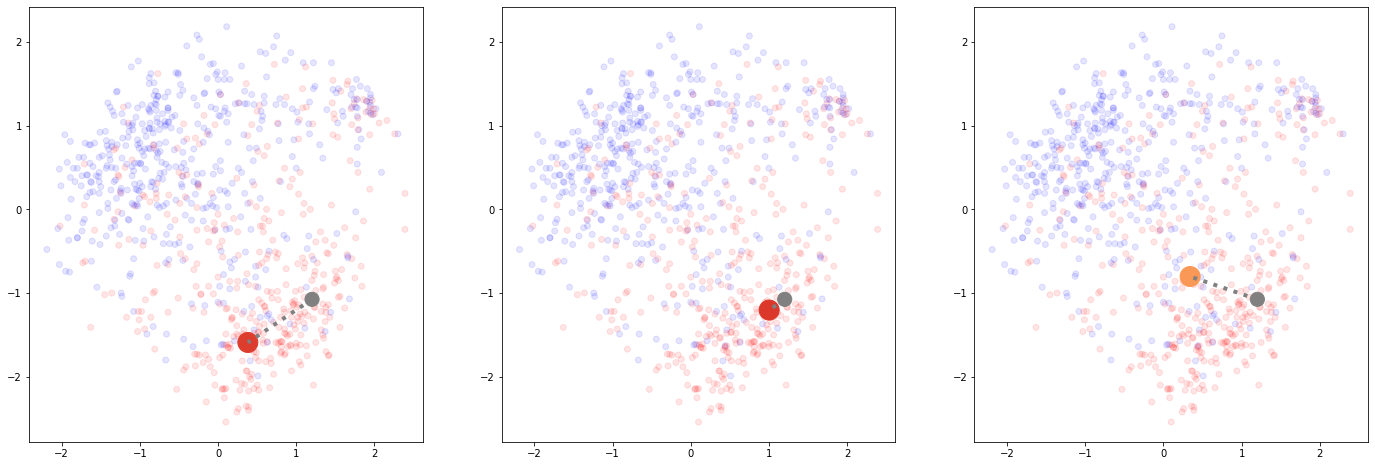

History for "Client 385" (Хорошая атака на неуверенный класс)


mcc_code  \
9                                                                                                                           5411: Бакалейные магазины, супермаркеты   
6  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
7  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
8  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
5                                                                                                      6011: Финансовые институты — снятие наличности автоматически   
4                                                                                                                           5411: Бакалейные магазины, супермаркеты   
3                                                                                                                           5411: Бакалейные магазины, супермаркеты   
2                                                                                                                           5411: Бакалейные магазины, супермаркеты   
1                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
0                                                                                                      6011: Финансовые институты — снятие наличности автоматически   

      amount  
9  11,100.00  
6  12,900.00  
7   5,500.00  
8   3,200.00  
5  89,800.00  
4  26,000.00  
3  17,700.00  
2   5,500.00  
1   1,100.00  
0 112,300.00

mcc_code  \
1                                                                                                            6010: Финансовые институты — снятие наличности вручную   
0  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   

      amount  
1 -70,300.00  
0  12,900.00

mcc_code  \
1                                4814: Звонки с использованием телефонов, считывающих магнитную ленту   
0  4111: Транспортировка — пригородные и локальные сезонные транспортные средства, включая электрички   

     amount  
1  2,200.00  
0 16,800.00

mcc_code    amount
1                                5977: Магазины косметики 41,200.00
0  6010: Финансовые институты — снятие наличности вручную -4,500.00

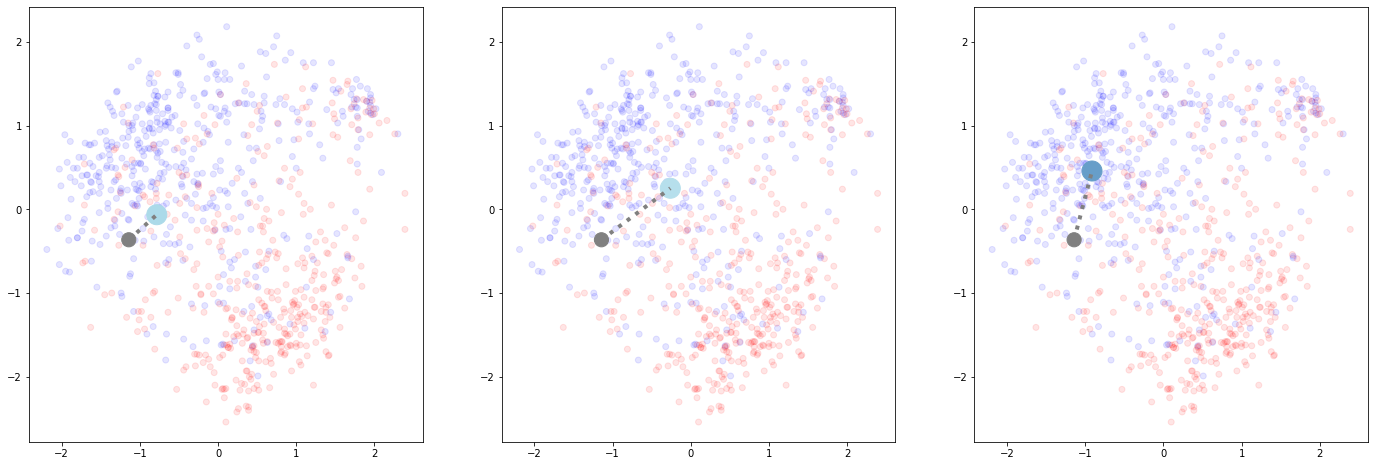

History for "Client 401" (Очень слабая атака на неуверенный класс)


mcc_code  \
9  4814: Звонки с использованием телефонов, считывающих магнитную ленту   
8  4814: Звонки с использованием телефонов, считывающих магнитную ленту   
7  4814: Звонки с использованием телефонов, считывающих магнитную ленту   
6  4814: Звонки с использованием телефонов, считывающих магнитную ленту   
5  4814: Звонки с использованием телефонов, считывающих магнитную ленту   
4          6011: Финансовые институты — снятие наличности автоматически   
3                               5411: Бакалейные магазины, супермаркеты   
2                               5411: Бакалейные магазины, супермаркеты   
1  4814: Звонки с использованием телефонов, считывающих магнитную ленту   
0          6011: Финансовые институты — снятие наличности автоматически   

      amount  
9   2,500.00  
8   2,200.00  
7   7,900.00  
6     700.00  
5     700.00  
4 336,900.00  
3   4,300.00  
2  18,200.00  
1   1,200.00  
0 202,100.00

mcc_code   amount
1  6011: Финансовые институты — снятие наличности автоматически 5,200.00
0                                                  5912: Аптеки 5,600.00

mcc_code     amount
1                                            5912: Аптеки  12,400.00
0  6010: Финансовые институты — снятие наличности вручную -21,900.00

mcc_code    amount
1  5943: Магазины офисных, школьных принадлежностей, канцтоваров 10,800.00
0                  5699: Различные магазины одежды и аксессуаров 36,800.00

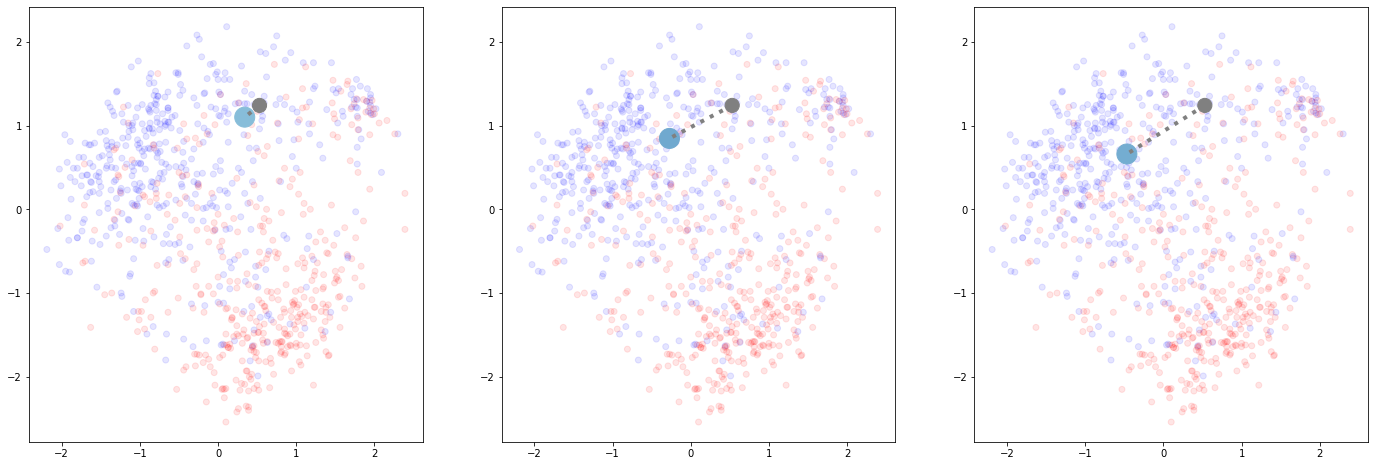

History for "Client 408" (Успешная атака на неуверенный класс)


mcc_code  \
9                                                                                         5921: Магазины с продажей спиртных напитков на вынос (пиво, вино и ликер)   
8                                                                                                                                      5331: Универсальные магазины   
7  5499: Различные продовольственные магазины — рынки, магазины со спец-ассортиментом, продажа полуфабрикатов, фирменных блюд, продажа с помощью торговых автоматов   
6                                                                                                                                      5331: Универсальные магазины   
4                                                                                                                          5999: Плавательные бассейны — распродажа   
5                                                                                                                          5999: Плавательные бассейны — распродажа   
3                                                                                                                                      5331: Универсальные магазины   
1                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
2                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   
0                                                                                              4814: Звонки с использованием телефонов, считывающих магнитную ленту   

     amount  
9  4,500.00  
8  8,200.00  
7 13,800.00  
6 13,900.00  
4 12,400.00  
5  4,400.00  
3 10,200.00  
1  6,700.00  
2  4,500.00  
0  9,000.00

mcc_code      amount
1  6011: Финансовые институты — снятие наличности автоматически -202,100.00
0                                 5541: Станции техобслуживания   17,400.00

mcc_code  \
1                     6011: Финансовые институты — снятие наличности автоматически   
0  5712: Оборудование, мебель и бытовые принадлежности (кроме электрооборудования)   

      amount  
1  51,700.00  
0 132,700.00

mcc_code    amount
1        5661: Обувные магазины 24,900.00
0  5621: Готовая женская одежда 41,300.00

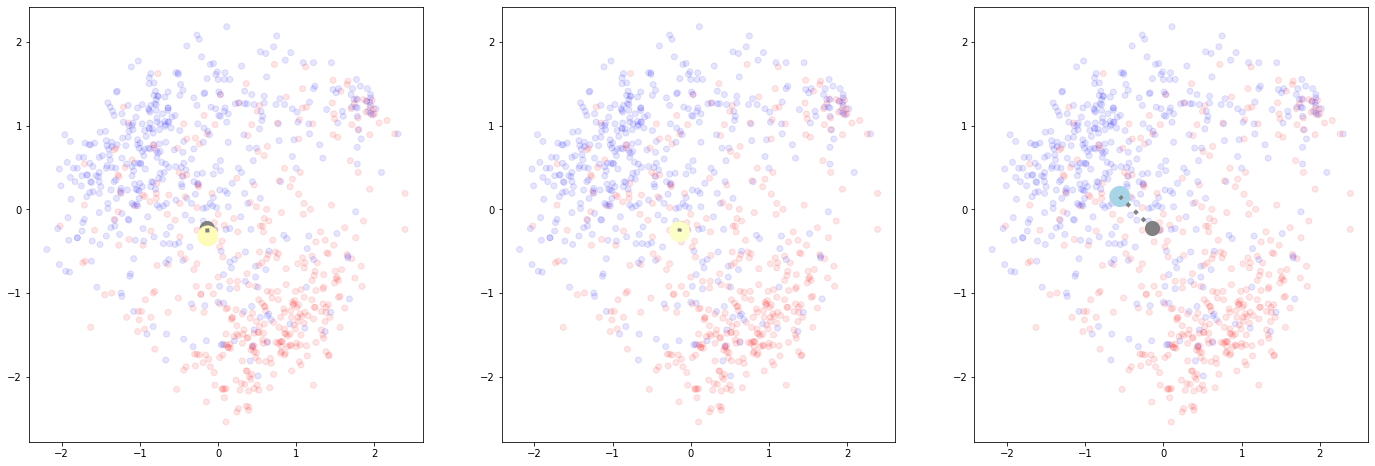

History for "Client 426" (Очень слабая атака на сильно уверенный класс)


mcc_code      amount
9            5812: Места общественного питания, рестораны   10,800.00
8                 5411: Бакалейные магазины, супермаркеты   12,400.00
7                 5411: Бакалейные магазины, супермаркеты   18,300.00
6                         5251: Скобяные товары в розницу   10,800.00
5                              5722: Бытовое оборудование  186,900.00
4  6010: Финансовые институты — снятие наличности вручную -186,900.00
3                 5411: Бакалейные магазины, супермаркеты   11,500.00
2                                            5912: Аптеки   26,500.00
1                     5211: Лесо- и строительный материал   15,600.00
0            5812: Места общественного питания, рестораны    2,100.00

mcc_code  \
1                                                          5912: Аптеки   
0  4814: Звонки с использованием телефонов, считывающих магнитную ленту   

    amount  
1 4,500.00  
0   200.00

mcc_code    amount
1  7399: Бизнес-сервис -5,600.00
0       5300: Оптовики 32,900.00

mcc_code    amount
1  5977: Магазины косметики 30,500.00
0  5977: Магазины косметики 30,500.00

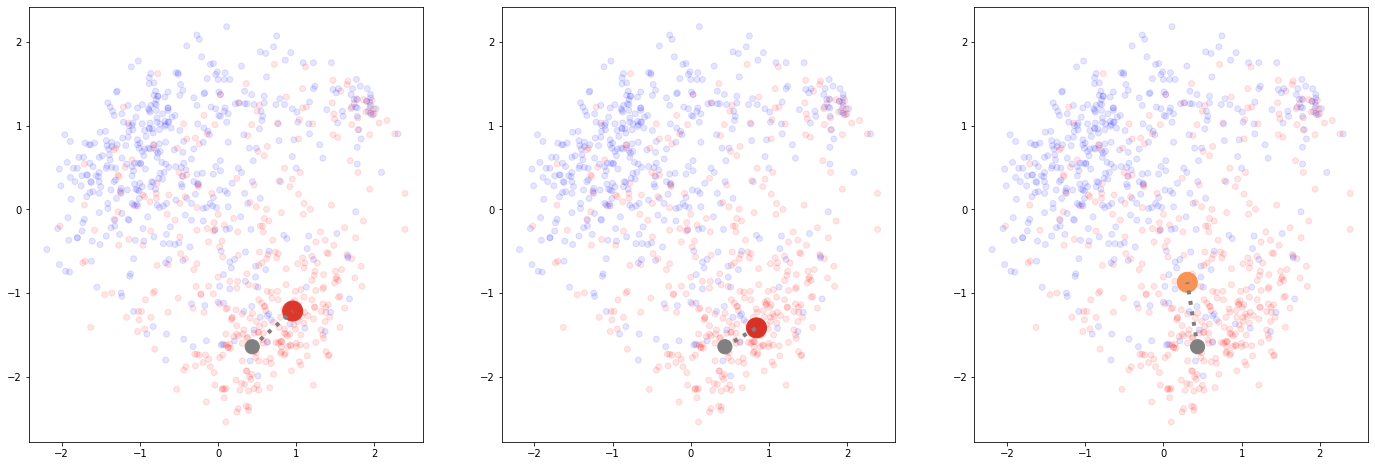

History for "Client 530" (Слабая атака на сильно уверенный класс)


mcc_code  \
8          6011: Финансовые институты — снятие наличности автоматически   
9          6011: Финансовые институты — снятие наличности автоматически   
7                                               4829: Денежные переводы   
6                6010: Финансовые институты — снятие наличности вручную   
5                                               4829: Денежные переводы   
3          6011: Финансовые институты — снятие наличности автоматически   
4                                               4829: Денежные переводы   
2          6011: Финансовые институты — снятие наличности автоматически   
1                                               4829: Денежные переводы   
0  4814: Звонки с использованием телефонов, считывающих магнитную ленту   

       amount  
8    9,000.00  
9    9,000.00  
7  617,200.00  
6 -779,300.00  
5      900.00  
3  -89,800.00  
4   89,800.00  
2  292,000.00  
1   22,500.00  
0    2,200.00

mcc_code  \
1                               5411: Бакалейные магазины, супермаркеты   
0  4814: Звонки с использованием телефонов, считывающих магнитную ленту   

    amount  
1 1,200.00  
0   200.00

mcc_code    amount
1  5983: Горючее топливо — уголь, нефть, разжиженный бензин, дрова 19,400.00
0                                                   5300: Оптовики 36,100.00

mcc_code    amount
1         5200: Товары для дома  5,700.00
0  5621: Готовая женская одежда 70,300.00

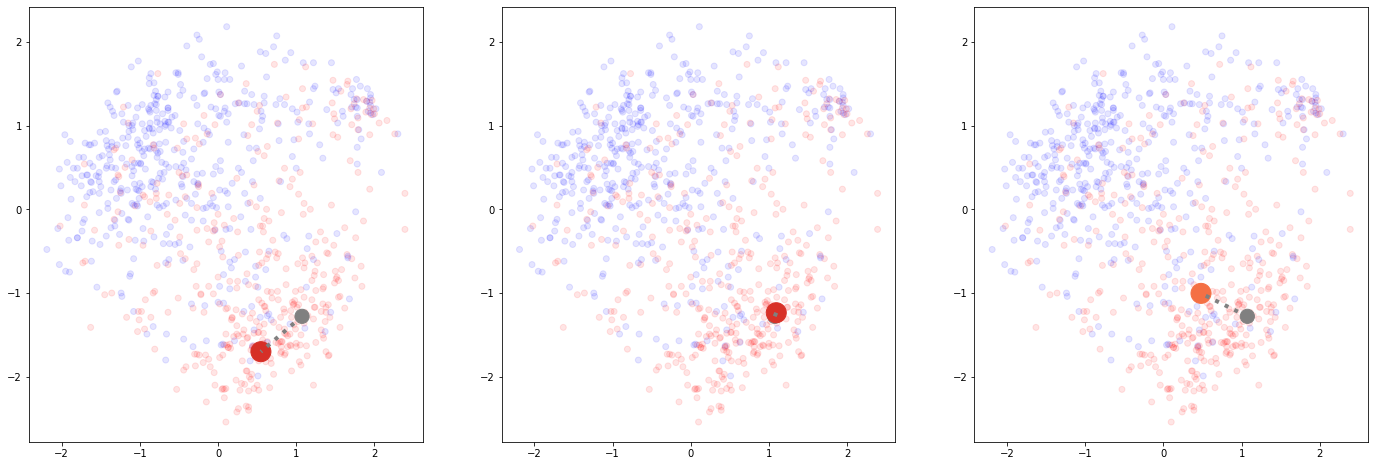

History for "Client 585" (Успешная атака на слабо уверенный класс)


mcc_code      amount
8  6011: Финансовые институты — снятие наличности автоматически   38,200.00
9  6011: Финансовые институты — снятие наличности автоматически    2,200.00
7        6010: Финансовые институты — снятие наличности вручную  -67,400.00
5        6010: Финансовые институты — снятие наличности вручную -190,900.00
6  6011: Финансовые институты — снятие наличности автоматически  190,900.00
4  6011: Финансовые институты — снятие наличности автоматически  213,400.00
3        6010: Финансовые институты — снятие наличности вручную -224,600.00
1        6010: Финансовые институты — снятие наличности вручную -112,300.00
2  6011: Финансовые институты — снятие наличности автоматически  112,300.00
0  6011: Финансовые институты — снятие наличности автоматически   67,400.00

mcc_code     amount
1  4829: Денежные переводы 127,400.00
0             5912: Аптеки  16,800.00

mcc_code  \
1                                                     7832: Кинотеатры   
0  5719: Различные специализированные магазины бытовых принадлежностей   

     amount  
1 16,100.00  
0 23,300.00

mcc_code    amount
1   5631: Аксессуары для женщин 10,900.00
0  5621: Готовая женская одежда 73,600.00

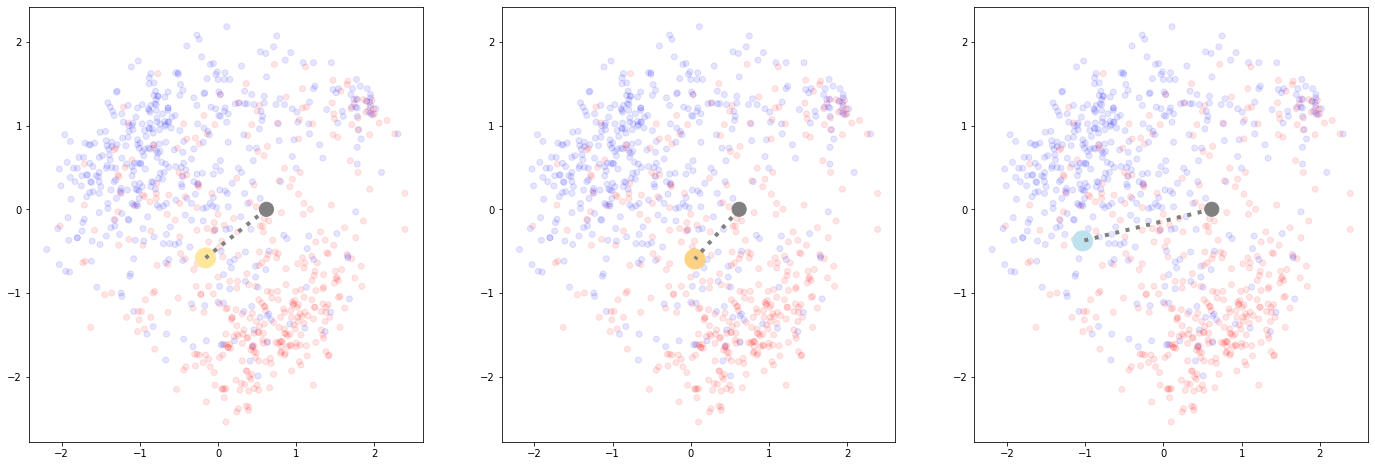

In [661]:
for x in chk_selected_trx:
    df = pd.DataFrame(x['trx'])
    df['mcc_code'] = df['mcc_code'].map(chk_mcc_dict)
    df['amount'] = np.round(df['amount'], -2)
    df = df.sort_values('event_time', ascending=False)
        
    sel_attack = None
    for a in chk_selected_attacks:
        if a['id'] == x['id']:
            sel_attack = a
            break
    assert a is not None
    print(f'History for "Client {x["id"]}" ({a["name"]})')
    with pd.option_context('display.float_format', '{:,.2f}'.format, 'display.max_colwidth', 500):
        display(df[['mcc_code', 'amount']])
    
    _, axs = plt.subplots(1, 3, figsize=(8 * 3, 8))
    for ax in axs:
        ax.scatter(
            [x['t_x_orig'] for x in chk_original_scores],
            [x['t_y_orig'] for x in chk_original_scores],
            c = ['red' if x['y'] == 1 else 'blue' for x in chk_original_scores],
            alpha=0.1,
        )
    for k, ax in zip(['most_popular', 'random', 'most_adversarial'], axs):
        ax.plot(
            [a[k]['t_x_orig'], a[k]['t_x']],
            [a[k]['t_y_orig'], a[k]['t_y']],
            color='gray', linestyle='dotted', linewidth=4,
        )
        ax.scatter(
            [a[k]['t_x_orig'], a[k]['t_x']],
            [a[k]['t_y_orig'], a[k]['t_y']], 
            s=[200, 400],
            c=[(0.5, 0.5, 0.5, 1.0), plt.get_cmap('RdYlBu_r')(a[k]['t_score'])],
        )
        df = pd.DataFrame(a[k]['new_trx'])
        df['mcc_code'] = df['mcc_code'].map(chk_mcc_dict)
        df['amount'] = np.round(df['amount'], -2)
        df = df.iloc[::-1]
        with pd.option_context('display.float_format', '{:,.2f}'.format, 'display.max_colwidth', 500):
            display(df[['mcc_code', 'amount']])
    
    plt.show()        

In [ ]:
# with pd.io.excel.ExcelWriter(f'client_{selected_ids[0][0]}_trx.xlsx') as f:
#     df_hist.to_excel(f, sheet_name='trx_history')
#     df1.to_excel(f, sheet_name='most_frequent')
#     df2.to_excel(f, sheet_name='random')
#     df3.to_excel(f, sheet_name='best adversarial')